# News Title Classification on Major News Sources

This notebook is an adaptation of another project to explore whether textual embeddings of news headlines can be linked to political orientation and sentiment. The primary goal is to investigate if we can identify the political orientation of news sources based on the textual context and words used in their article headlines.

Given that I had previously scraped news headlines data during another project, I thought it would be a cool idea to investigate this further. The steps in this notebook include:

- **Clustering and Visualization**:
  - Visualize PC2 and PC3 of the TF-IDF matrix to see if there are any patterns.
  - Visualize confusion matrix for clustering results.
- **Clustering**: 
  - Reprocess data with outliers and perform clustering again.
  - Apply spectral clustering and compare with K-Means.
  - Attempt classification on all news sources.
  - Attempt classification specifically on CNN and Fox News given their differing political orientations.
  
### Enhanced Textual Embeddings with BERT LLM & Advanced Clustering

To enhance the textual embeddings we can try out a transformer-based embeddings such as BERT. To get a through understanding of how more complex models perform, DBSCAN and Hierarchical Clustering are also applied and compared.

- **Transformer-based Embeddings**:
  - Generate embeddings using a pre-trained BERT model.
  - Generate embeddings using a fine-tuned BERT model specifically for news headlines.
- **Advanced Clustering**:
  - Apply DBSCAN clustering and visualize the results.
  - Apply Agglomerative Clustering and visualize the results.
  - Compare the clustering results using confusion matrices.
  - Visualize the embeddings using PCA and t-SNE for both base and fine-tuned BERT models.

In [3]:
import glob
import importlib
import os
import sys
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

from DataImporter import DataImporter
from FeatureExtraction import FeatureExtraction
from ModelTraining import ModelTraining
from TextPreprocessing import TextPreprocessing
from Tf_Idf_Machine import Tf_Idf_Machine
from Visualizations import Visualizations

warnings.filterwarnings("ignore")
plt.style.use('dark_background')

Successfully Started Program
Importing Data...


In [224]:
import pickle
def load_session_variables():
    with open('session_variables.pkl', 'rb') as f:
        picklable_session_variables = pickle.load(f)
    globals().update(picklable_session_variables)

load_session_variables()

In [5]:
%whos

Variable                       Type                       Data/Info
-------------------------------------------------------------------
DataImporter                   type                       <class 'DataImporter.DataImporter'>
FeatureExtraction              type                       <class 'FeatureExtraction.FeatureExtraction'>
In                             list                       n=25
KElbowVisualizer               type                       <class 'yellowbrick.clust<...>.elbow.KElbowVisualizer'>
KMeans                         ABCMeta                    <class 'sklearn.cluster._kmeans.KMeans'>
ModelTraining                  type                       <class 'ModelTraining.ModelTraining'>
PCA                            ABCMeta                    <class 'sklearn.decomposition._pca.PCA'>
SpectralClustering             type                       <class 'sklearn.cluster._<...>tral.SpectralClustering'>
TextPreprocessing              type                       <class 'TextPreprocessi

In [199]:
preprocessor = TextPreprocessing()
featureExtractor = FeatureExtraction()
modelTraining = ModelTraining()
visualizations = Visualizations()

def load_data(keep):
    files = glob.glob('**/*.csv', recursive=True)
    dfs = []
    for file in files:
        df = pd.read_csv(file)
        df = df.dropna()
        df = df.drop_duplicates()
        df = df.reset_index(drop=True)
        dfs.append(df)

    documents = pd.concat(dfs)

    political_orientation = {source: i + 1 for i, source in enumerate(keep)}

    documents_unfiltered = documents

    print("Data Preprocessing initialized. Will take a few minutes... Please Wait...")
    documents = documents[documents['source'].isin(keep)]
    documents = documents.reset_index(drop=True)
    documents = documents.drop_duplicates(subset=['title'])
    documents = documents.reset_index(drop=True)
    documents = documents.sort_values(by=['source'])
    documents = documents.reset_index(drop=True)
    source_dict = dict(zip(documents['source'].unique(), range(len(documents['source'].unique()))))

    for i in range(len(documents)):
        documents.loc[i,'source_num'] = source_dict[documents.loc[i,'source']]
    documents['source_num'] = documents['source_num'].astype(int)
    documents['source_num'].value_counts()
    documents = documents.groupby('source_num').head(200)
    documents = documents.reset_index(drop=True)
    documents['source_num'].value_counts()
    return documents, documents_unfiltered, political_orientation



keep = [
        'CNN',
        'Associated Press',
        'Newsweek',
        'Fox News'
        ]
documents, documents_unfiltered, political_orientation = load_data(keep)


Data Preprocessing initialized. Will take a few minutes... Please Wait...


In [4]:
documents = documents.drop_duplicates(subset=['title'])
documents = documents.reset_index(drop=True)
documents = documents.sort_values(by=['source'])
documents = documents.reset_index(drop=True)
source_dict = dict(zip(documents['source'].unique(), range(len(documents['source'].unique()))))

for i in range(len(documents)):
    documents.loc[i,'source_num'] = source_dict[documents.loc[i,'source']]
documents['source_num'] = documents['source_num'].astype(int)
documents['source_num'].value_counts()
documents = documents.groupby('source_num').head(200)
documents = documents.reset_index(drop=True)
documents['source_num'].value_counts()

source_num
0    200
1    200
2    200
3    200
Name: count, dtype: int64

In [5]:
import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')
docList = documents['title'].tolist()
cleaned_tokens_all = []
cleaned_docs = []
corpus = []
for doc in docList:
    preprocessed = preprocessor.preprocess_text(doc)
    ner_results = preprocessor.combind_ner(preprocessed)
    merge_desired_bigrams = preprocessor.get_desired_bigrams(ner_results, [])
    cleaned_tokens_all.extend(merge_desired_bigrams)
    cleaned_docs.append(merge_desired_bigrams)

In [6]:
corpus = []
for doc in cleaned_docs:
    corpus.append(' '.join(doc))
tf_idf_all = featureExtractor.gen_term_matrix(corpus)
tf_idf = featureExtractor.gen_term_matrix(corpus)
cosine_similarities = modelTraining.get_cosine_sim(tf_idf)

print("News Title classification on 4 news sources keep ['CNN', 'Associated Press', 'Newsweek', 'Fox News']")

News Title classification on 4 news sources keep ['CNN', 'Associated Press', 'Newsweek', 'Fox News']


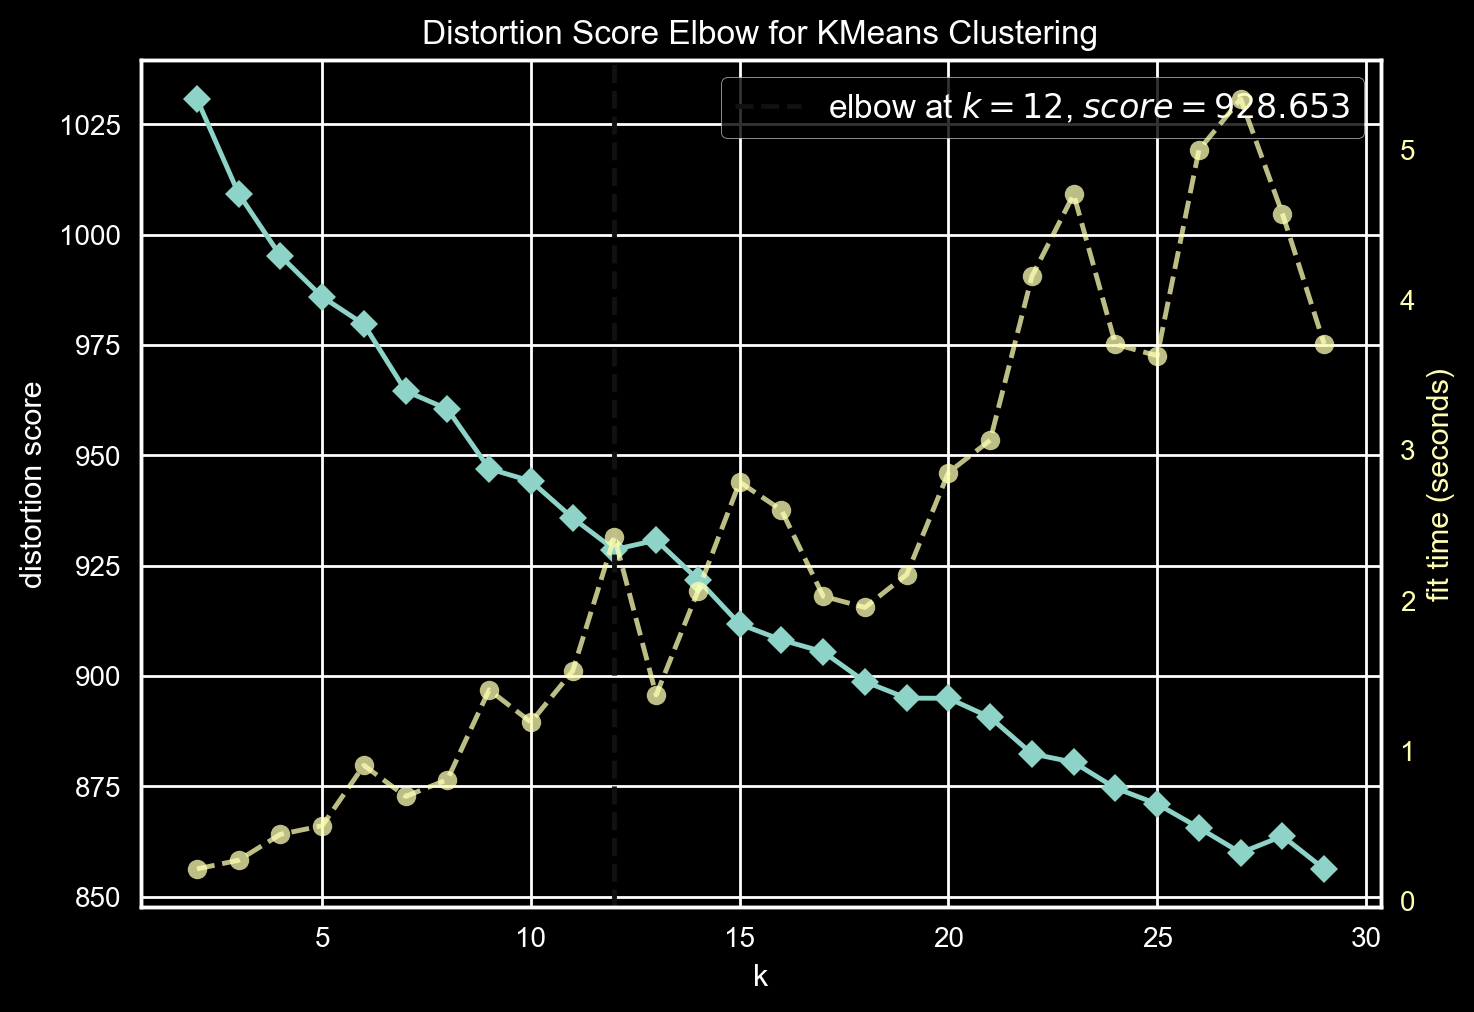

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
from yellowbrick.cluster import KElbowVisualizer
plt.style.use('dark_background')
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(cosine_similarities)  
visualizer.show()

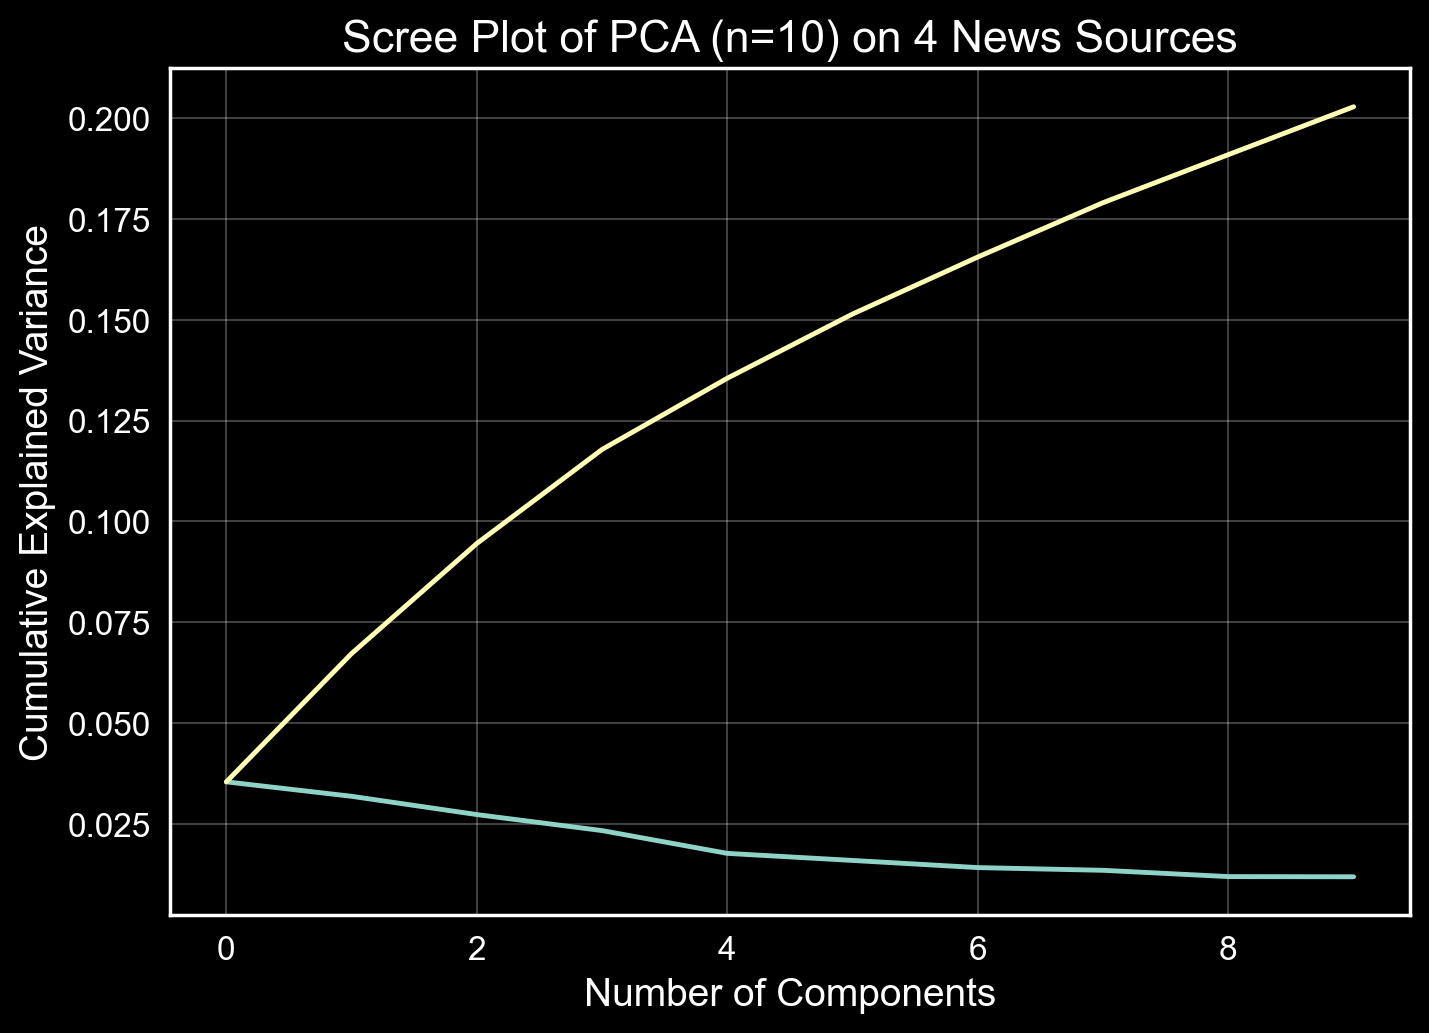

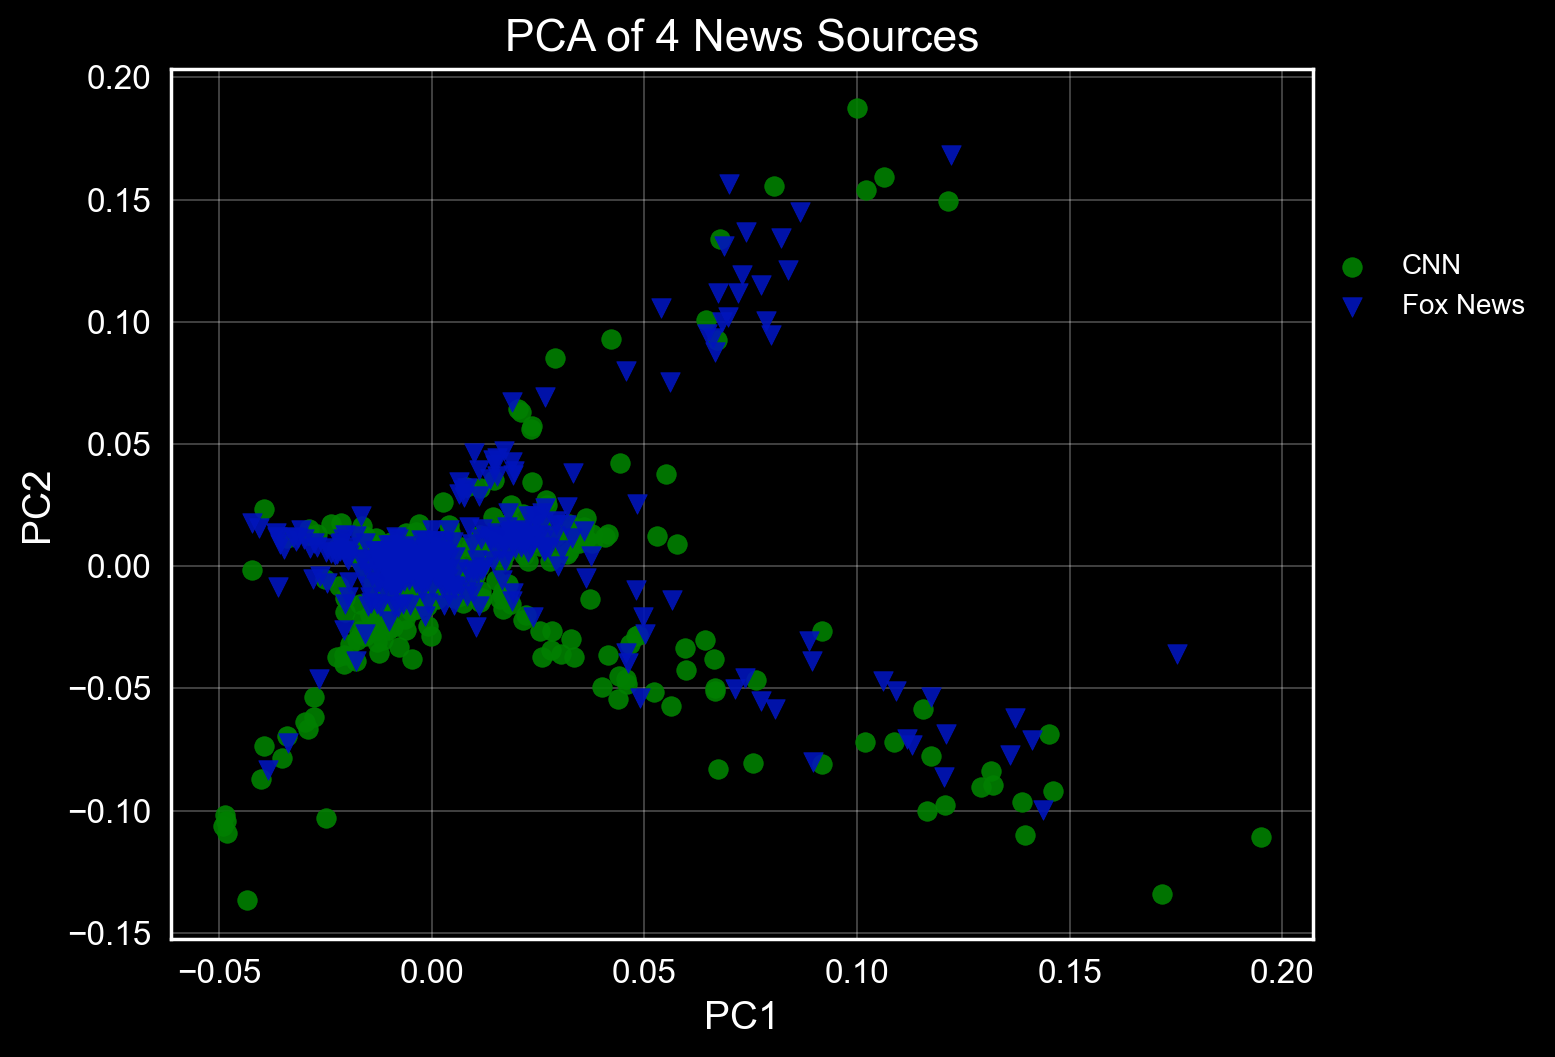

In [225]:
load_session_variables()

pca = PCA(10)
pca.fit(cosine_similarities)
plt.style.use('dark_background')
plt.figure()
plt.plot(pca.explained_variance_)
plt.plot(np.cumsum(pca.explained_variance_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot of PCA (n=10) on 4 News Sources')
plt.show()

plt.figure()
colors = [ 'green', '#0015bc','#ff0000', 'purple']  # Define colors for each source
markers = ['o', 'v', '^', '<']  # Define markers for each source

for i, source in enumerate(documents['source'].unique()):
    plt.scatter(pca.components_[0][documents['source_num'] == i], 
                pca.components_[1][documents['source_num'] == i], 
                color=colors[i], 
                marker=markers[i],  # Use different marker for each source
                label=source,
                alpha=0.9)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of 4 News Sources')
plt.legend(bbox_to_anchor=(1, .8), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

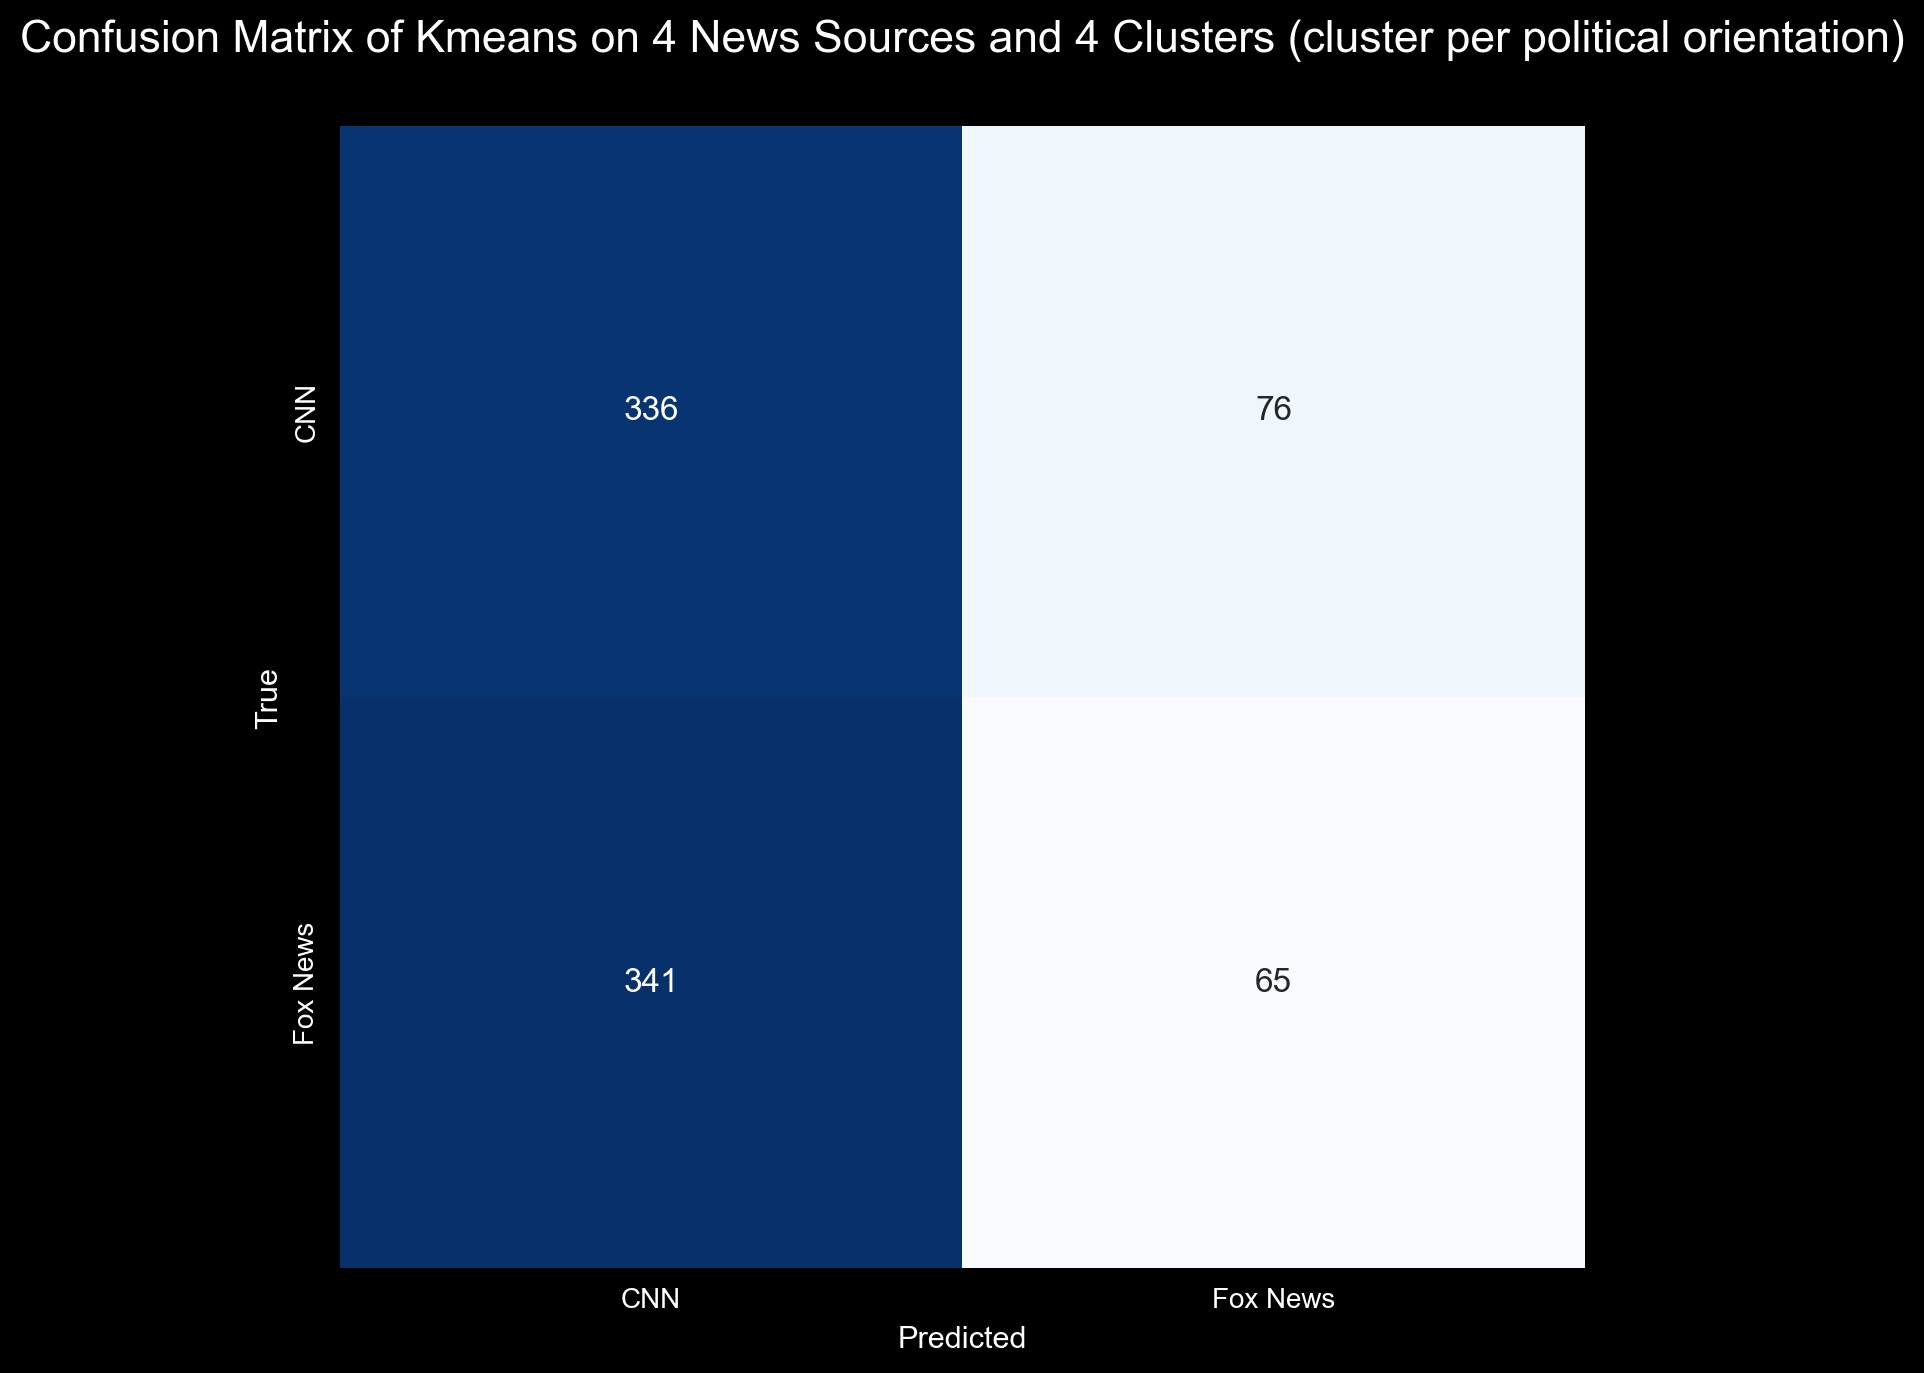

In [60]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(cosine_similarities)
documents['kmeans'] = kmeans.labels_
resultsDf = documents[['source','source_num','kmeans','title', 'sentimentScore']]

# Create a mapping from source_num to source
source_mapping = documents[['source', 'source_num']].drop_duplicates().set_index('source_num')['source'].to_dict()

# Replace the numeric labels in the kmeans column with the corresponding source names
documents['kmeans_mapped'] = documents['kmeans'].map(source_mapping)

# Update the rest of your code to use the new labels
resultsDf = documents[['source','source_num','kmeans_mapped', 'kmeans', 'title', 'sentimentScore']]

plt.figure(figsize=(7, 7))
sns.heatmap(pd.crosstab(resultsDf['source'], resultsDf['kmeans_mapped']), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Kmeans on 4 News Sources and 4 Clusters (cluster per political orientation)', size=16, y=1.05)
plt.tight_layout()
plt.show()

In [10]:
extremes = resultsDf[resultsDf['kmeans'] >= 1][['source', 'source_num', 'title','kmeans']]

print("Removed Non-Outliers. Preprocessing data again with only outliers... Please wait... ")
docList_extremes = extremes['title'].tolist()
cleaned_tokens_all = []
cleaned_docs_extremes = []
corpus_extremes = []
for doc in docList_extremes:
    preprocessed = preprocessor.preprocess_text(doc)
    ner_results = preprocessor.combind_ner(preprocessed)
    merge_desired_bigrams = preprocessor.get_desired_bigrams(ner_results, [])
    cleaned_tokens_all.extend(merge_desired_bigrams)
    cleaned_docs_extremes.append(merge_desired_bigrams)
    corpus_extremes.append(' '.join(merge_desired_bigrams))

Removed Non-Outliers. Preprocessing data again with only outliers... Please wait... 


In [8]:
source_mapping

{0: 'Associated Press', 1: 'CNN', 2: 'Fox News', 3: 'Newsweek'}

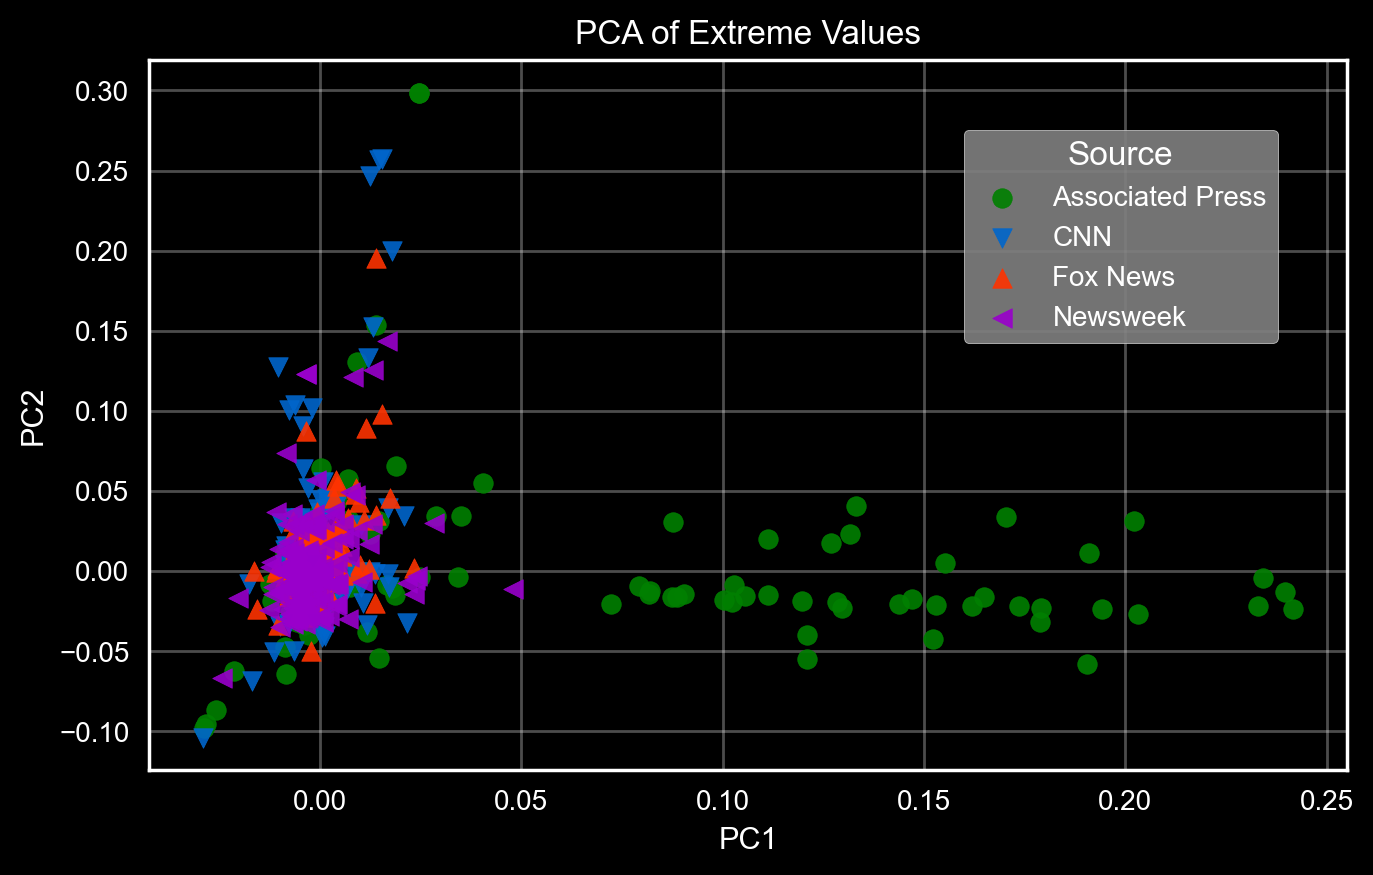

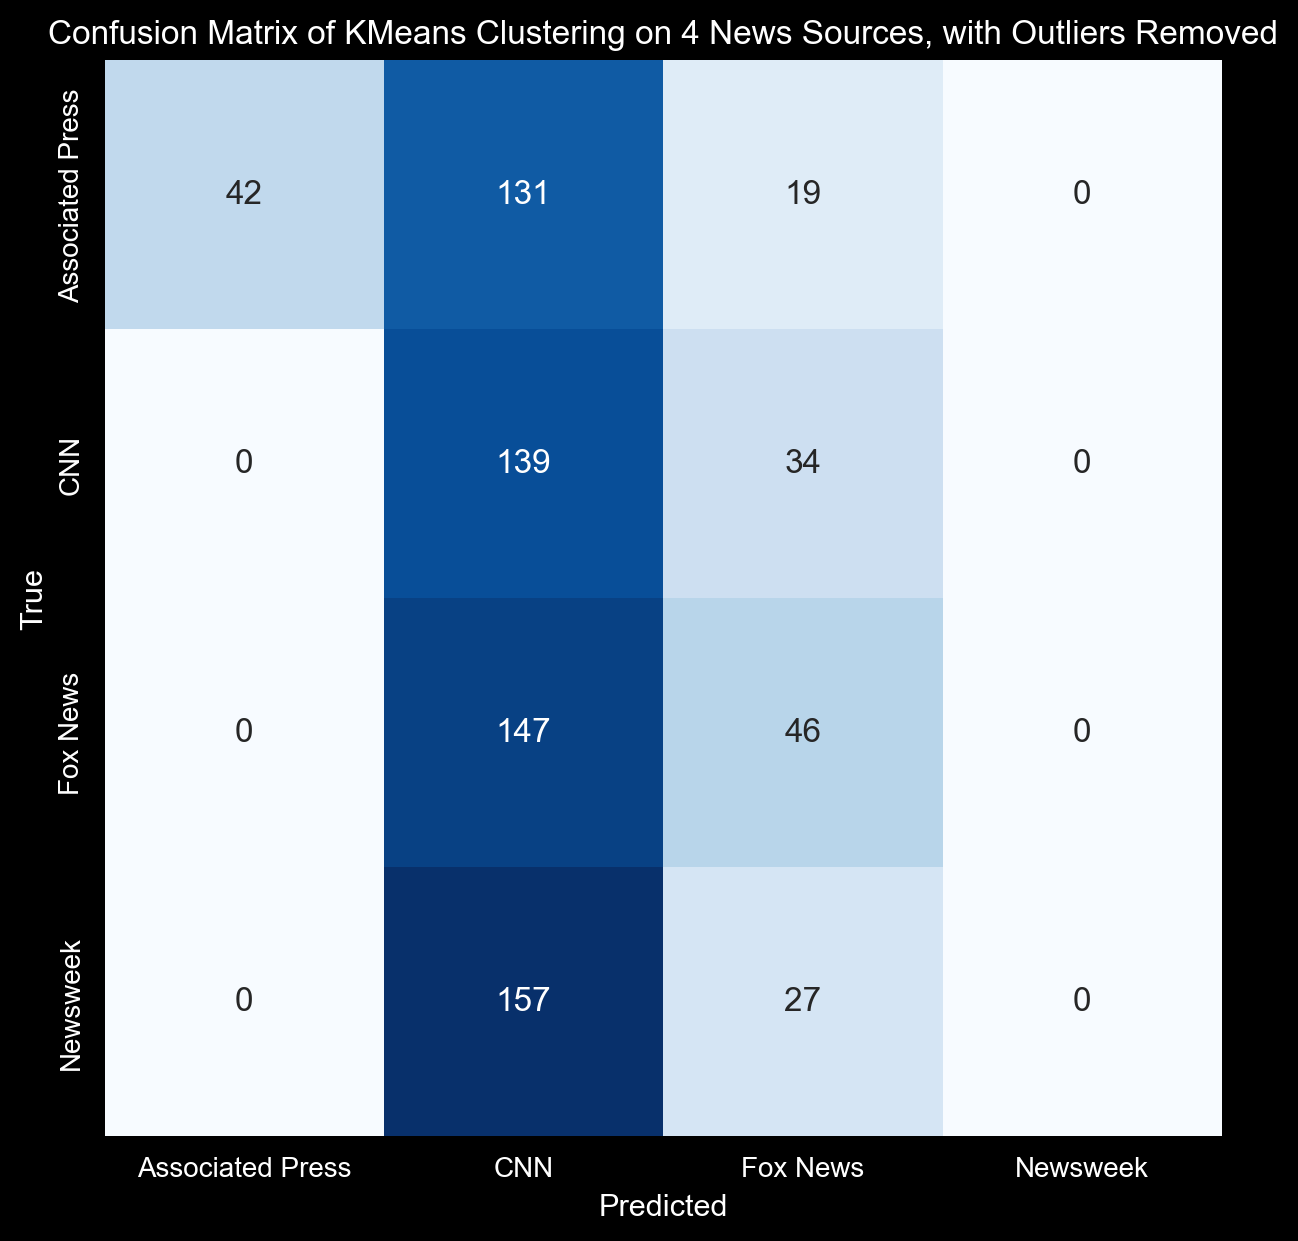

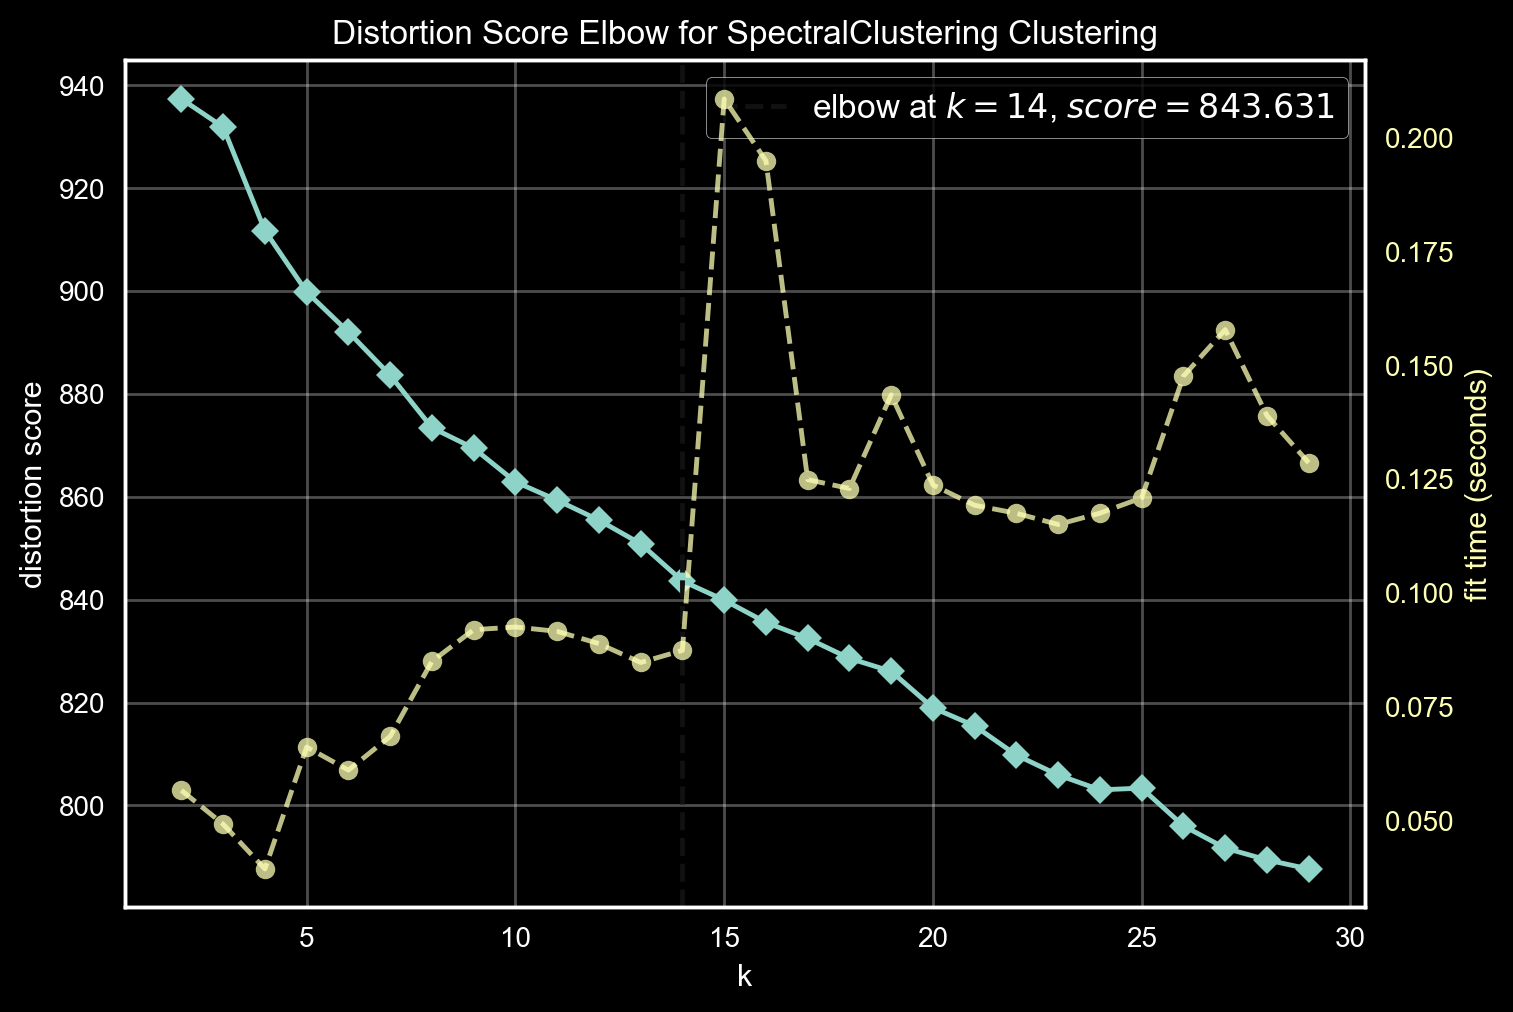

<Axes: title={'center': 'Distortion Score Elbow for SpectralClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
tf_idf_extremes = featureExtractor.gen_term_matrix(corpus_extremes)
cosine_similarities_extremes = modelTraining.get_cosine_sim(tf_idf_extremes)
source_mapping = {0: 'Associated Press', 1: 'CNN', 2: 'Fox News', 3: 'Newsweek'}

pca = PCA(n_components=10)
pca.fit(cosine_similarities_extremes)
plt.figure()
colors = ['green', '#0015bc', '#ff0000', 'purple']
colors = ['green', '#0066cc', '#ff3300', '#9900cc']
markers = ['o', 'v', '^', '<'] 

for i, source in enumerate(extremes['source'].unique()):
    plt.scatter(pca.components_[0][extremes['source_num'] == i], 
                pca.components_[1][extremes['source_num'] == i], 
                color=colors[i], 
                marker=markers[i], 
                label=source,
                alpha=0.9)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Extreme Values')
plt.legend(loc='upper right', borderaxespad=2.5, frameon=True, title='Source', facecolor='gray', framealpha=0.9)
plt.tight_layout(pad=4)
plt.show()


plt.figure(figsize=(7, 7))
heatmap = sns.heatmap(confusion_matrix(extremes['source_num'], extremes['kmeans']), annot=True, fmt='d', cmap='Blues',cbar=False)
heatmap.set_xticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_xticklabels()])
heatmap.set_yticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_yticklabels()])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of KMeans Clustering on 4 News Sources, with Outliers Removed')
plt.tight_layout(pad=3)
plt.show()

model = SpectralClustering()
visualizer = KElbowVisualizer(model, k=(2,30), timings=True)
visualizer.fit(cosine_similarities_extremes)
visualizer.show()

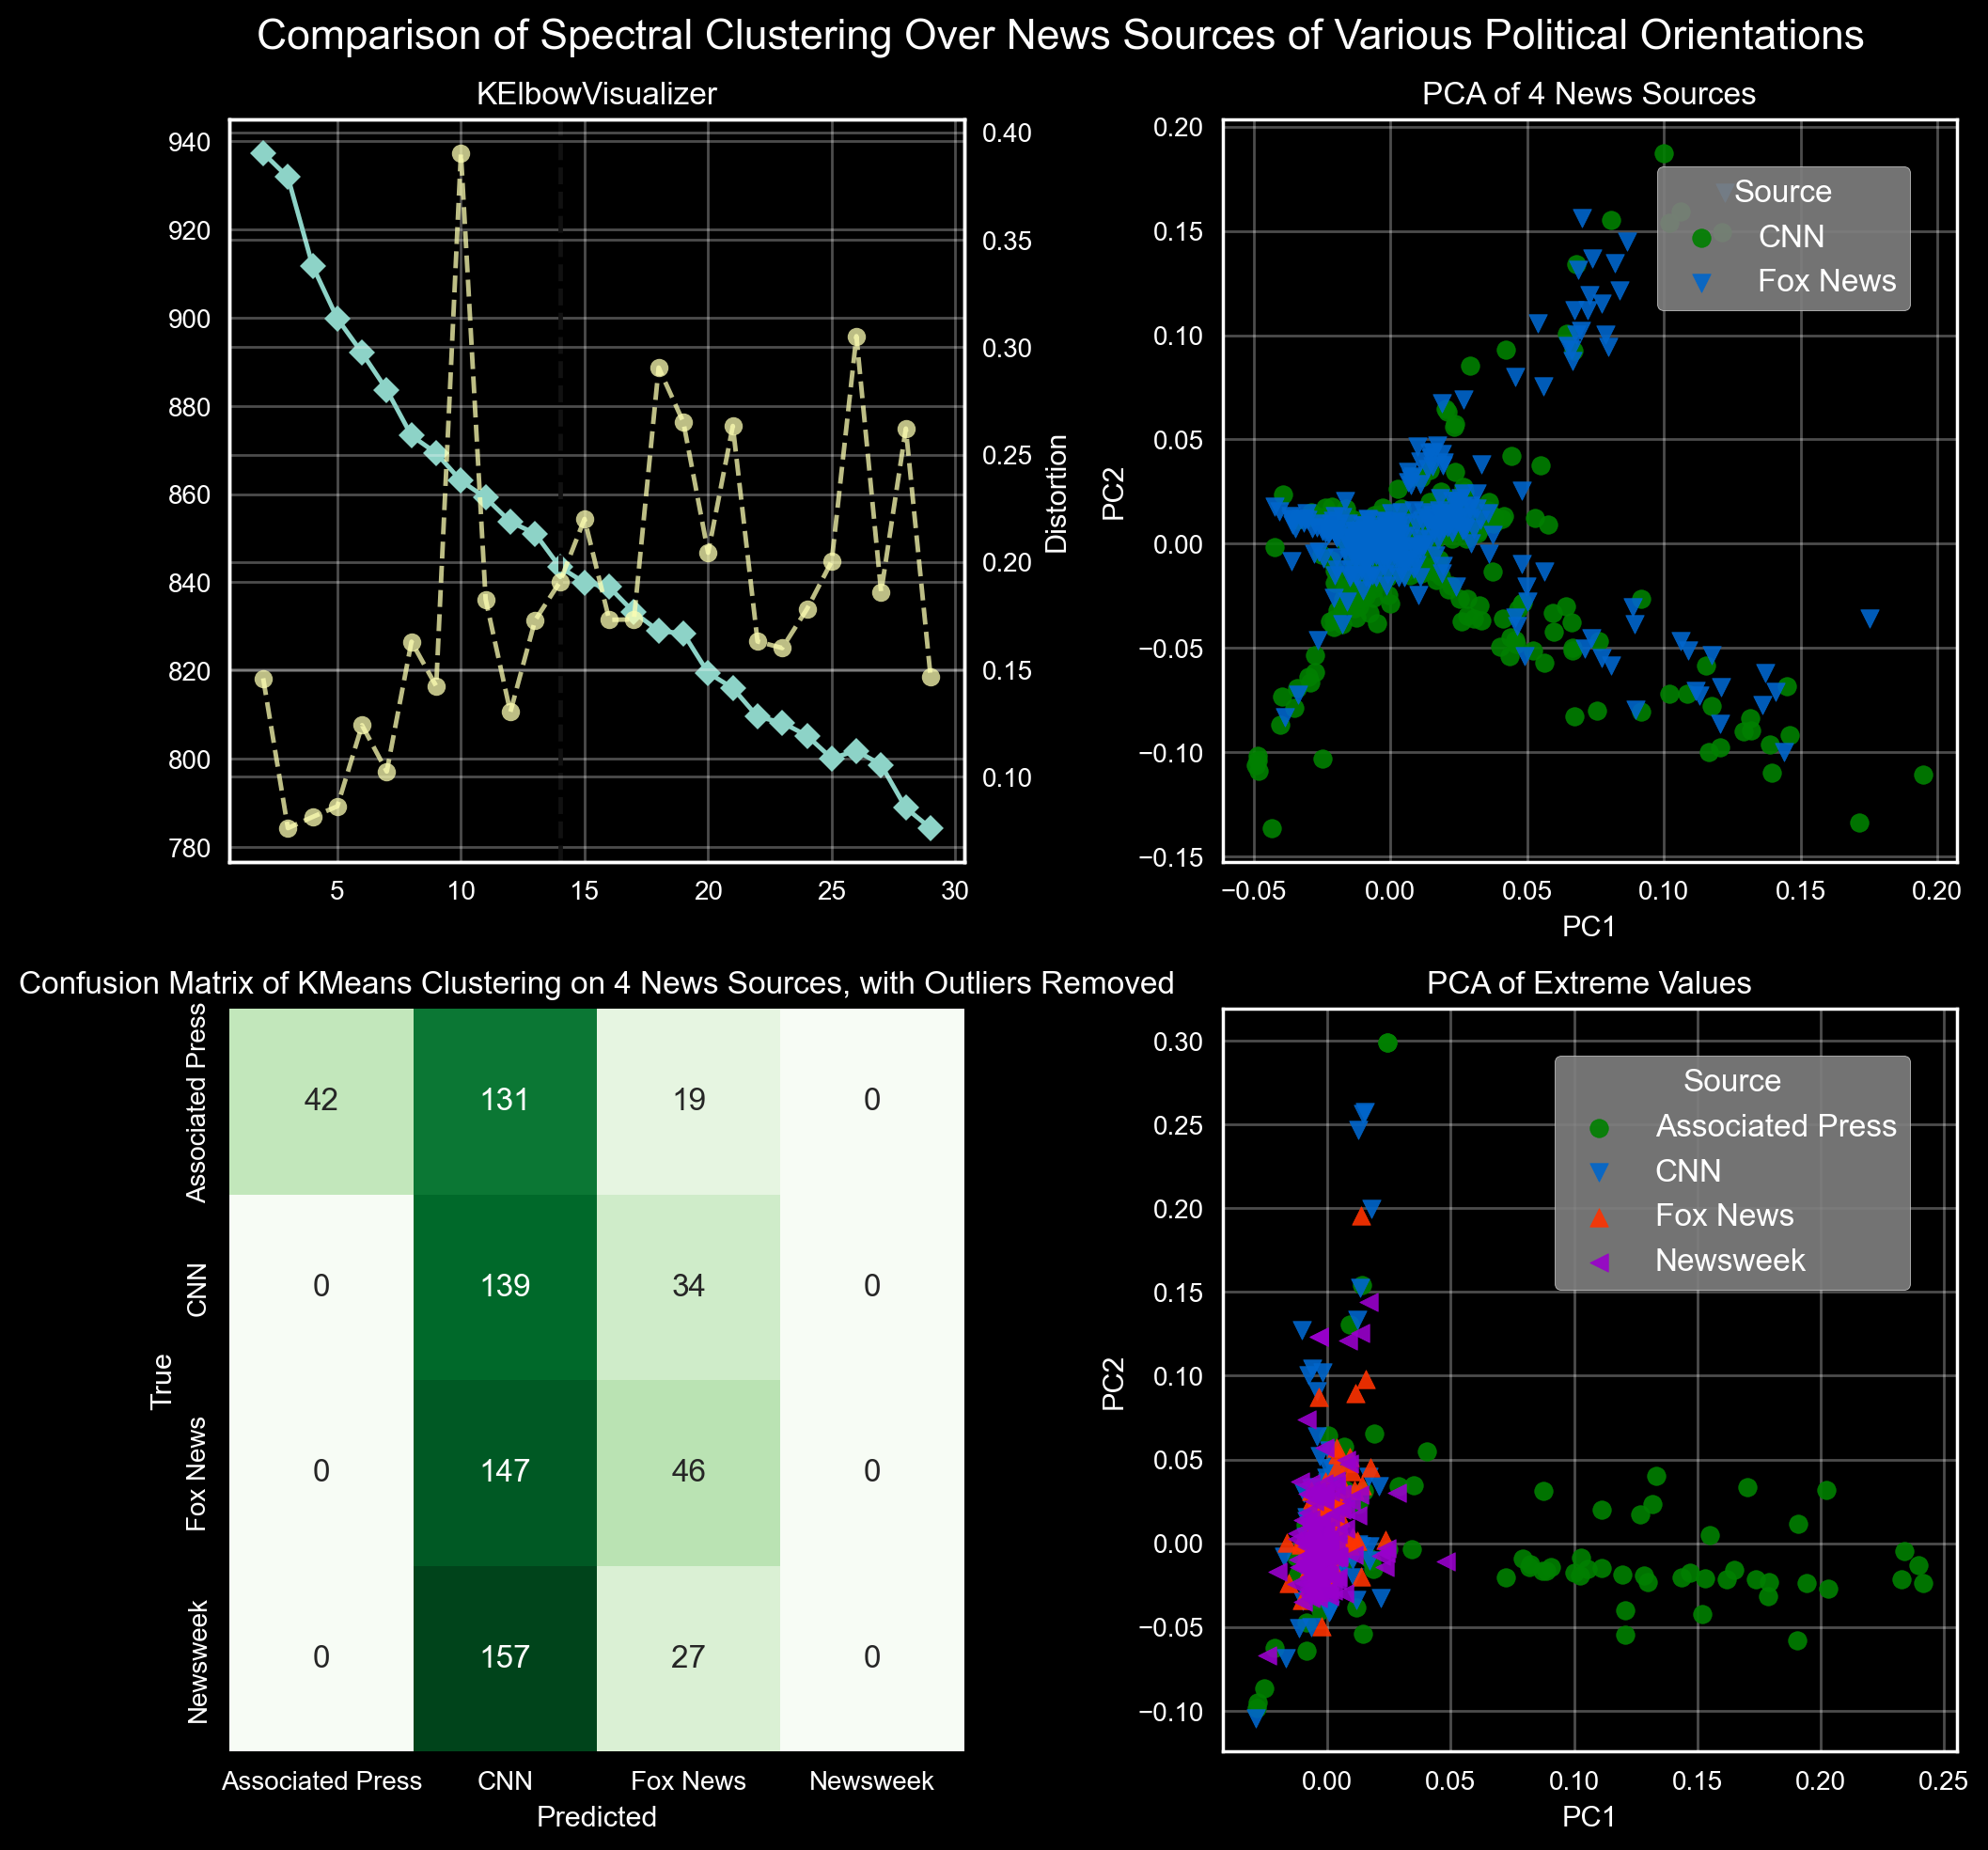

In [82]:
fig = plt.figure(figsize=(10, 10))

# First subplot
plt.subplot(221)

model = SpectralClustering()
visualizer = KElbowVisualizer(model, k=(2,30), timings=True)
visualizer.fit(cosine_similarities_extremes)
plt.title('KElbowVisualizer')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')


# Second subplot
plt.subplot(222)


colors = [ 'green', '#0015bc','#ff0000', 'purple']  # Define colors for each source
colors = ['green', '#0066cc', '#ff3300', '#9900cc']
markers = ['o', 'v', '^', '<']  # Define markers for each source
pca = PCA(10)
pca.fit(cosine_similarities)
for i, source in enumerate(documents['source'].unique()):
    plt.scatter(pca.components_[0][documents['source_num'] == i], 
                pca.components_[1][documents['source_num'] == i], 
                color=colors[i], 
                marker=markers[i],  # Use different marker for each source
                label=source,
                alpha=0.9)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of 4 News Sources')
plt.legend(loc='upper right', borderaxespad=1.5, frameon=True, title='Source', facecolor='gray', framealpha=0.9, fontsize=12)
plt.tight_layout()

plt.subplot(223)
heatmap = sns.heatmap(confusion_matrix(extremes['source_num'], extremes['kmeans']), annot=True, fmt='d', cmap='Greens',cbar=False)
heatmap.set_xticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_xticklabels()])
heatmap.set_yticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_yticklabels()])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of KMeans Clustering on 4 News Sources, with Outliers Removed')

# Third subplot
plt.subplot(224)

tf_idf_extremes = featureExtractor.gen_term_matrix(corpus_extremes)
cosine_similarities_extremes = modelTraining.get_cosine_sim(tf_idf_extremes)
pca = PCA(n_components=10)
pca.fit(cosine_similarities_extremes)

for i, source in enumerate(extremes['source'].unique()):
    plt.scatter(pca.components_[0][extremes['source_num'] == i], 
                pca.components_[1][extremes['source_num'] == i], 
                color=colors[i], 
                marker=markers[i], 
                label=source,
                alpha=0.9)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Extreme Values', size=12)
plt.legend(loc='upper right', borderaxespad=1.5, frameon=True, title='Source', facecolor='gray', framealpha=0.9, fontsize=12)

plt.suptitle('Comparison of Spectral Clustering Over News Sources of Various Political Orientations', size=16)

plt.tight_layout(pad=1)
plt.show()

In [182]:
plt.rcParams['figure.constrained_layout.use'] = False

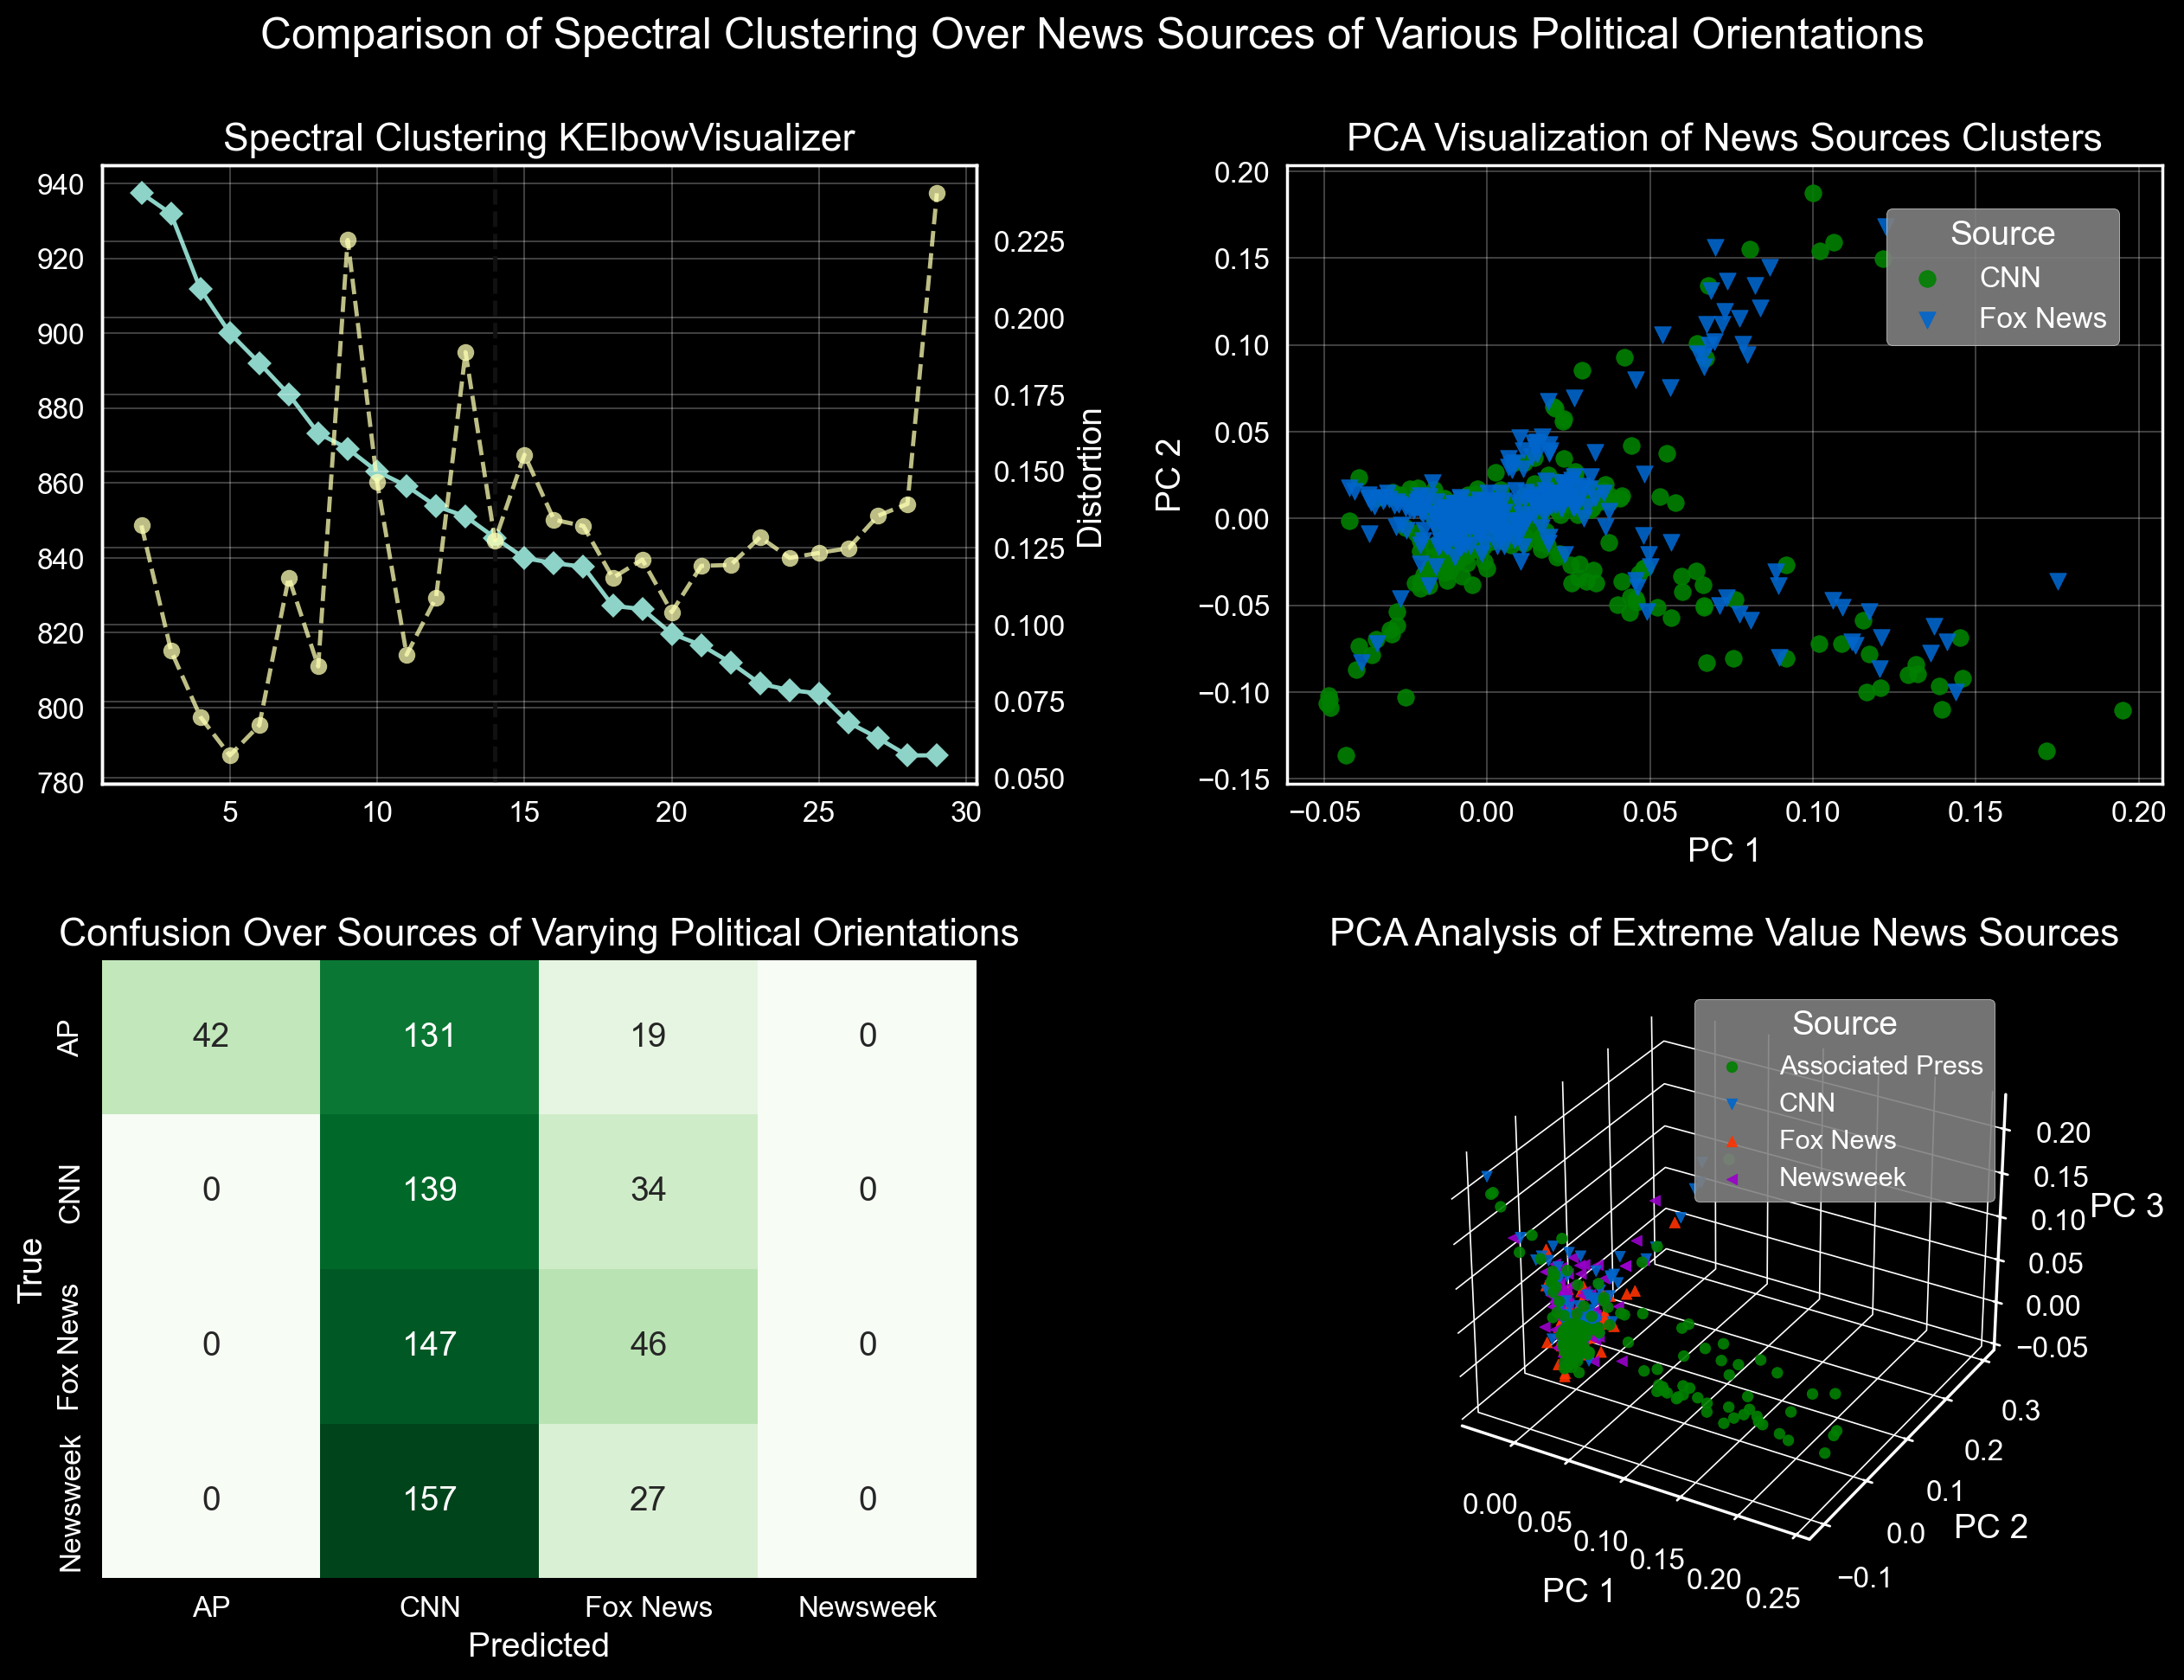

In [184]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl

# Save original settings
original_rc_params = mpl.rcParams.copy()

# Update font sizes
mpl.rcParams.update({
    'font.size': 14,  # Change default font size
    'axes.titlesize': 16,  # Increase title font size
    'axes.labelsize': 14,  # Increase label font size
    'xtick.labelsize': 12,  # Increase x-axis tick label font size
    'ytick.labelsize': 12,  # Increase y-axis tick label font size
})

fig = plt.figure(figsize=(13, 10))

# First subplot
plt.subplot(221)
model = SpectralClustering()
visualizer = KElbowVisualizer(model, k=(2,30), timings=True)
visualizer.fit(cosine_similarities_extremes)
plt.title('Spectral Clustering KElbowVisualizer')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')

# Second subplot
plt.subplot(222)
colors = ['green', '#0066cc', '#ff3300', '#9900cc']
markers = ['o', 'v', '^', '<']
pca = PCA(10)
pca.fit(cosine_similarities)
for i, source in enumerate(documents['source'].unique()):
    plt.scatter(pca.components_[0][documents['source_num'] == i], 
                pca.components_[1][documents['source_num'] == i], 
                color=colors[i], 
                marker=markers[i],  
                label=source,
                alpha=0.9)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Visualization of News Sources Clusters')
plt.legend(loc='upper right', borderaxespad=1.5, frameon=True, title='Source', facecolor='gray', framealpha=0.9, fontsize=12)
plt.tight_layout()

plt.subplot(223)
source_mapping = {0: 'AP', 1: 'CNN', 2: 'Fox News', 3: 'Newsweek'}
heatmap = sns.heatmap(confusion_matrix(extremes['source_num'], extremes['kmeans']), annot=True, fmt='d', cmap='Greens',cbar=False)
heatmap.set_xticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_xticklabels()])
heatmap.set_yticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_yticklabels()])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Over Sources of Varying Political Orientations')


# Fourth subplot
ax = fig.add_subplot(224, projection='3d', facecolor='black', )
ax.grid(color='black', linestyle='-',  alpha=0.2)  # Reduced alpha for grid lines
tf_idf_extremes = featureExtractor.gen_term_matrix(corpus_extremes)
cosine_similarities_extremes = modelTraining.get_cosine_sim(tf_idf_extremes)
pca = PCA(n_components=10)
pca.fit(cosine_similarities_extremes)
for i, source in enumerate(extremes['source'].unique()):
    ax.scatter(pca.components_[0][extremes['source_num'] == i], 
               pca.components_[1][extremes['source_num'] == i], 
               pca.components_[2][extremes['source_num'] == i], 
               color=colors[i], 
               marker=markers[i], 
               label=source,
               alpha=0.9)
ax.set_xlabel('PC 1', labelpad=12)
ax.set_ylabel('PC 2', labelpad=12)
ax.set_zlabel('PC 3', labelpad=12)
ax.set_title('PCA Analysis of Extreme Value News Sources')
ax.legend(loc='upper right', borderaxespad=1.5, frameon=True, title='Source',  framealpha=0.9, fontsize=11,facecolor='gray')

# Update the grid background color to black
ax.xaxis.set_pane_color((0, 0, 0, 1))
ax.yaxis.set_pane_color((0, 0, 0, 1))
ax.zaxis.set_pane_color((0, 0, 0, 1))

# plt.subplots_adjust(hspace=0.5, right=0.6, top=0.9)
# fig.subplots_adjust(hspace=0.5, right=0.6)
plt.suptitle('Comparison of Spectral Clustering Over News Sources of Various Political Orientations', size=18)
plt.tight_layout(pad=1.5)
plt.show()

mpl.rcParams.update(original_rc_params)

In [13]:
print('\n\n\n===================== Attempting Classification on CNN and Fox News Only================')
print('Confusion Matrix of Kmeans on CNN and Fox News. n=2 cluster')

files = glob.glob('**/*.csv',recursive=True)
dfs = []
for file in files:
    df = pd.read_csv(file)
    df = df.dropna()
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    dfs.append(df)

documents = pd.concat(dfs) 

keep = ['CNN', 'Fox News']
documents = documents[documents['source'].isin(keep)]
documents = documents.drop_duplicates(subset=['title'])
documents = documents.reset_index(drop=True)
documents = documents.sort_values(by=['source'])
documents = documents.reset_index(drop=True)

source_dict = dict(zip(documents['source'].unique(), range(len(documents['source'].unique()))))
for i in range(len(documents)):
    documents.loc[i,'source_num'] = source_dict[documents.loc[i,'source']]
documents['source_num'] = documents['source_num'].astype(int)
documents['source_num'].value_counts()

documents = documents.groupby('source_num').head(450)
documents = documents.reset_index(drop=True)
documents['source_num'].value_counts()

docList = documents['title'].tolist()
cleaned_tokens_all = []
cleaned_docs = []
corpus = []
for doc in docList:
    preprocessed = preprocessor.preprocess_text(doc)
    ner_results = preprocessor.combind_ner(preprocessed)
    merge_desired_bigrams = preprocessor.get_desired_bigrams(ner_results, [])
    cleaned_tokens_all.extend(merge_desired_bigrams)
    cleaned_docs.append(merge_desired_bigrams)
    corpus.append(' '.join(merge_desired_bigrams))




===================== Attempting Classification on CNN and Fox News Only================
Confusion Matrix of Kmeans on CNN and Fox News. n=2 cluster


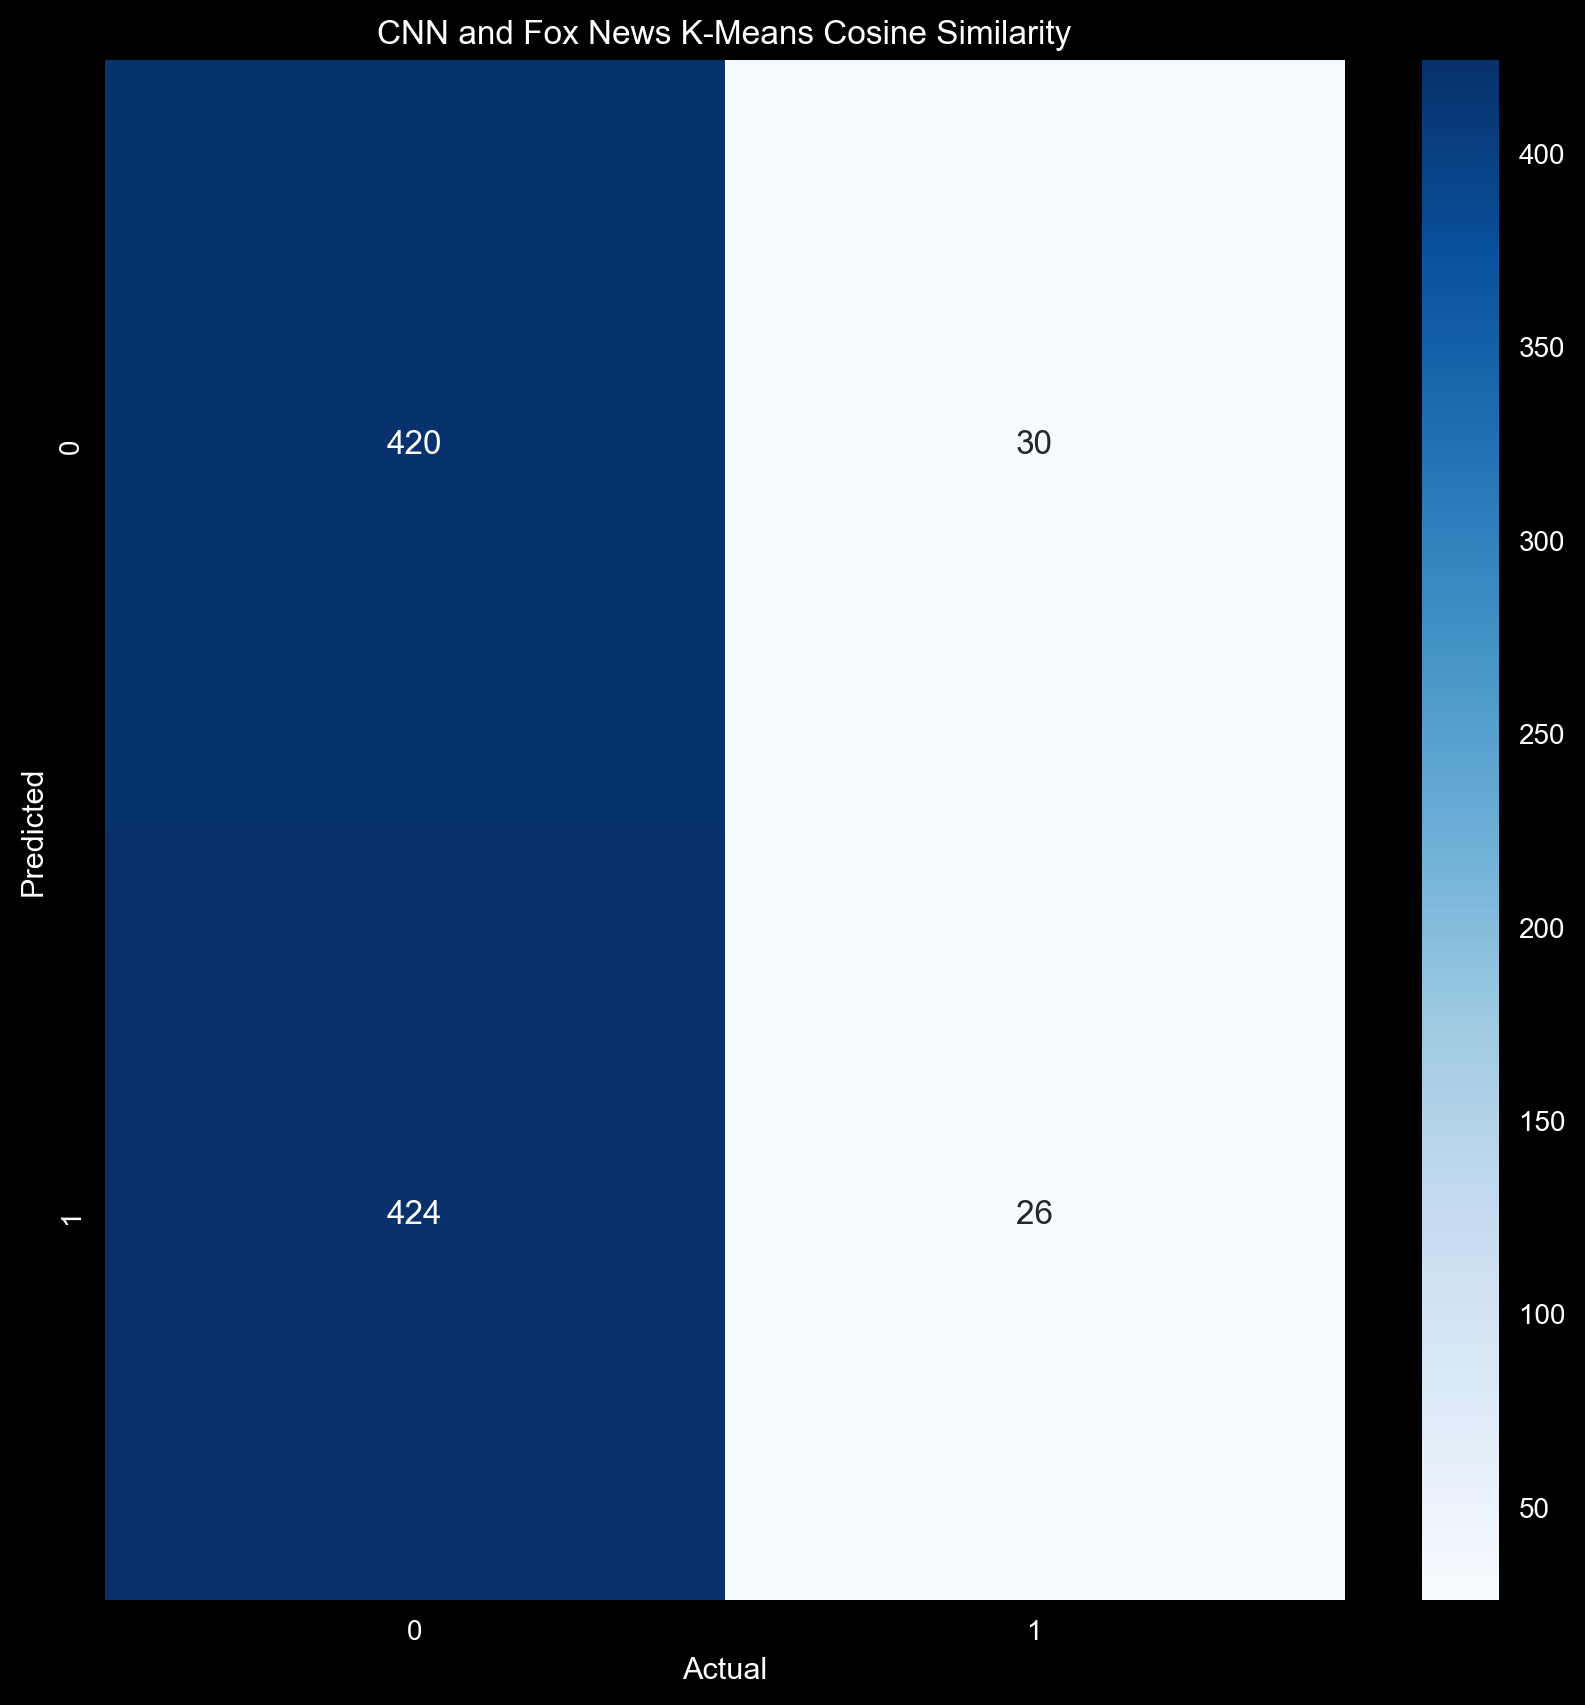

In [14]:
tf_idf_all = featureExtractor.gen_term_matrix(corpus)
tf_idf = featureExtractor.gen_term_matrix(corpus)
cosine_similarities = modelTraining.get_cosine_sim(tf_idf)

from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
X = model.fit_transform(corpus)
words = model.get_feature_names_out()
word2idx = dict(zip(words, range(len(words))))

# train a k-means model
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
documents['kmeans'] = kmeans.labels_
resultsDf = documents[['source', 'source_num', 'sentimentScore', 'kmeans', 'title']]

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(resultsDf['source_num'], resultsDf['kmeans']), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('CNN and Fox News K-Means Cosine Similarity')
plt.show()

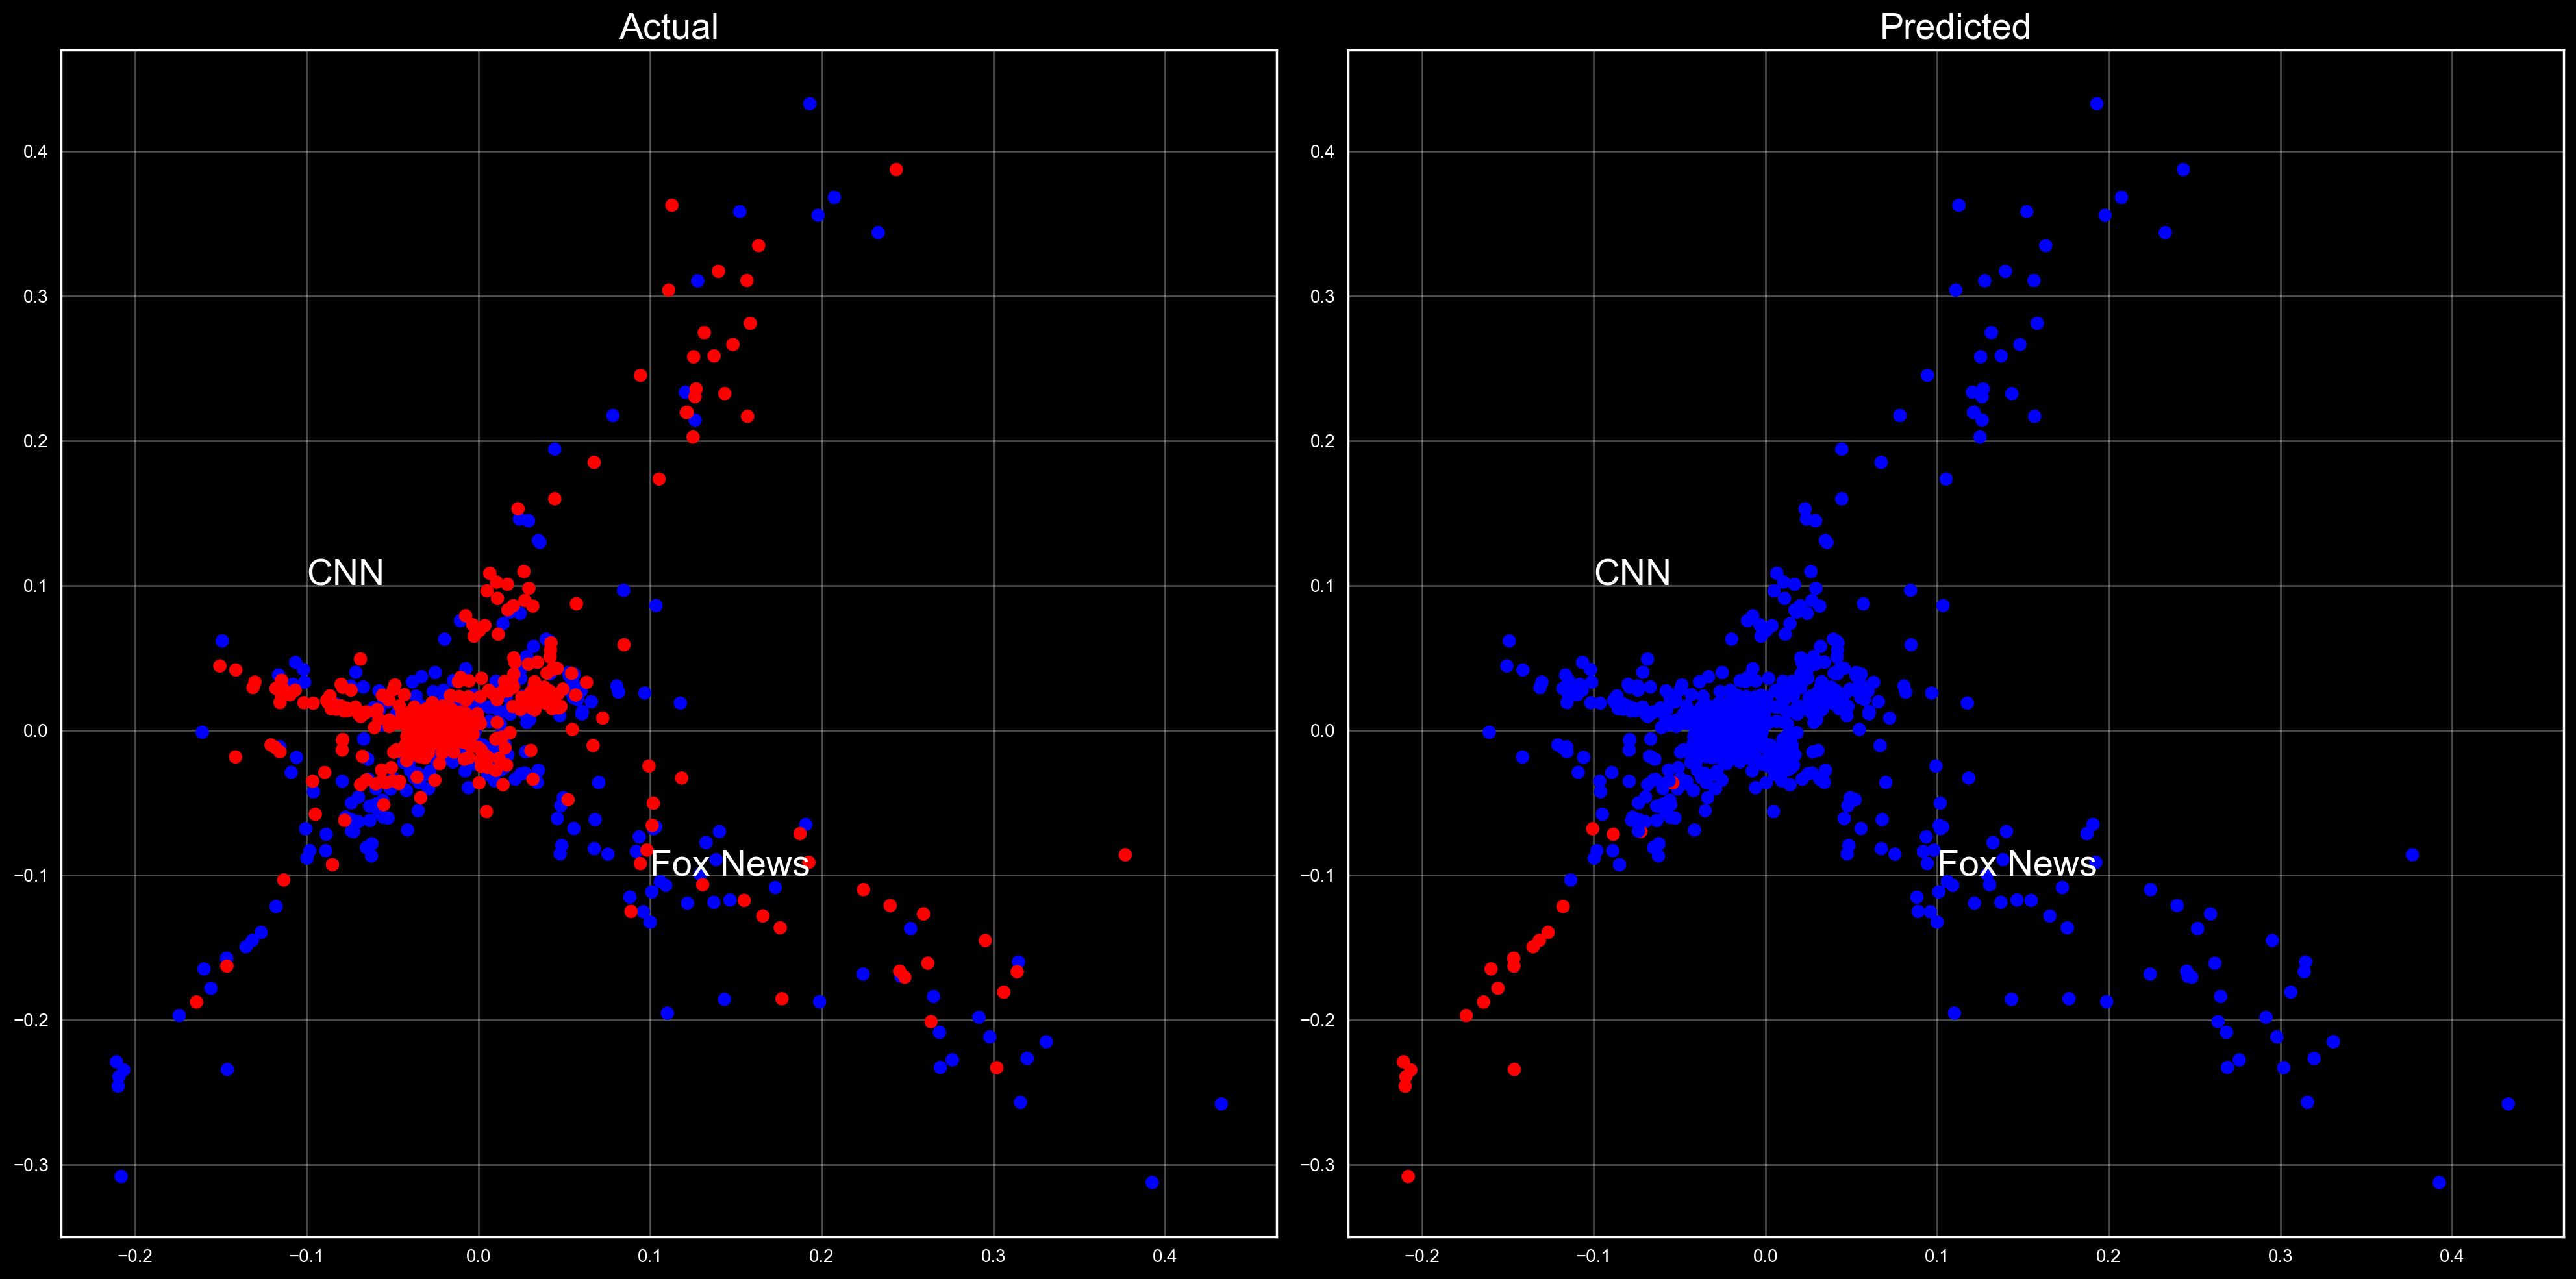

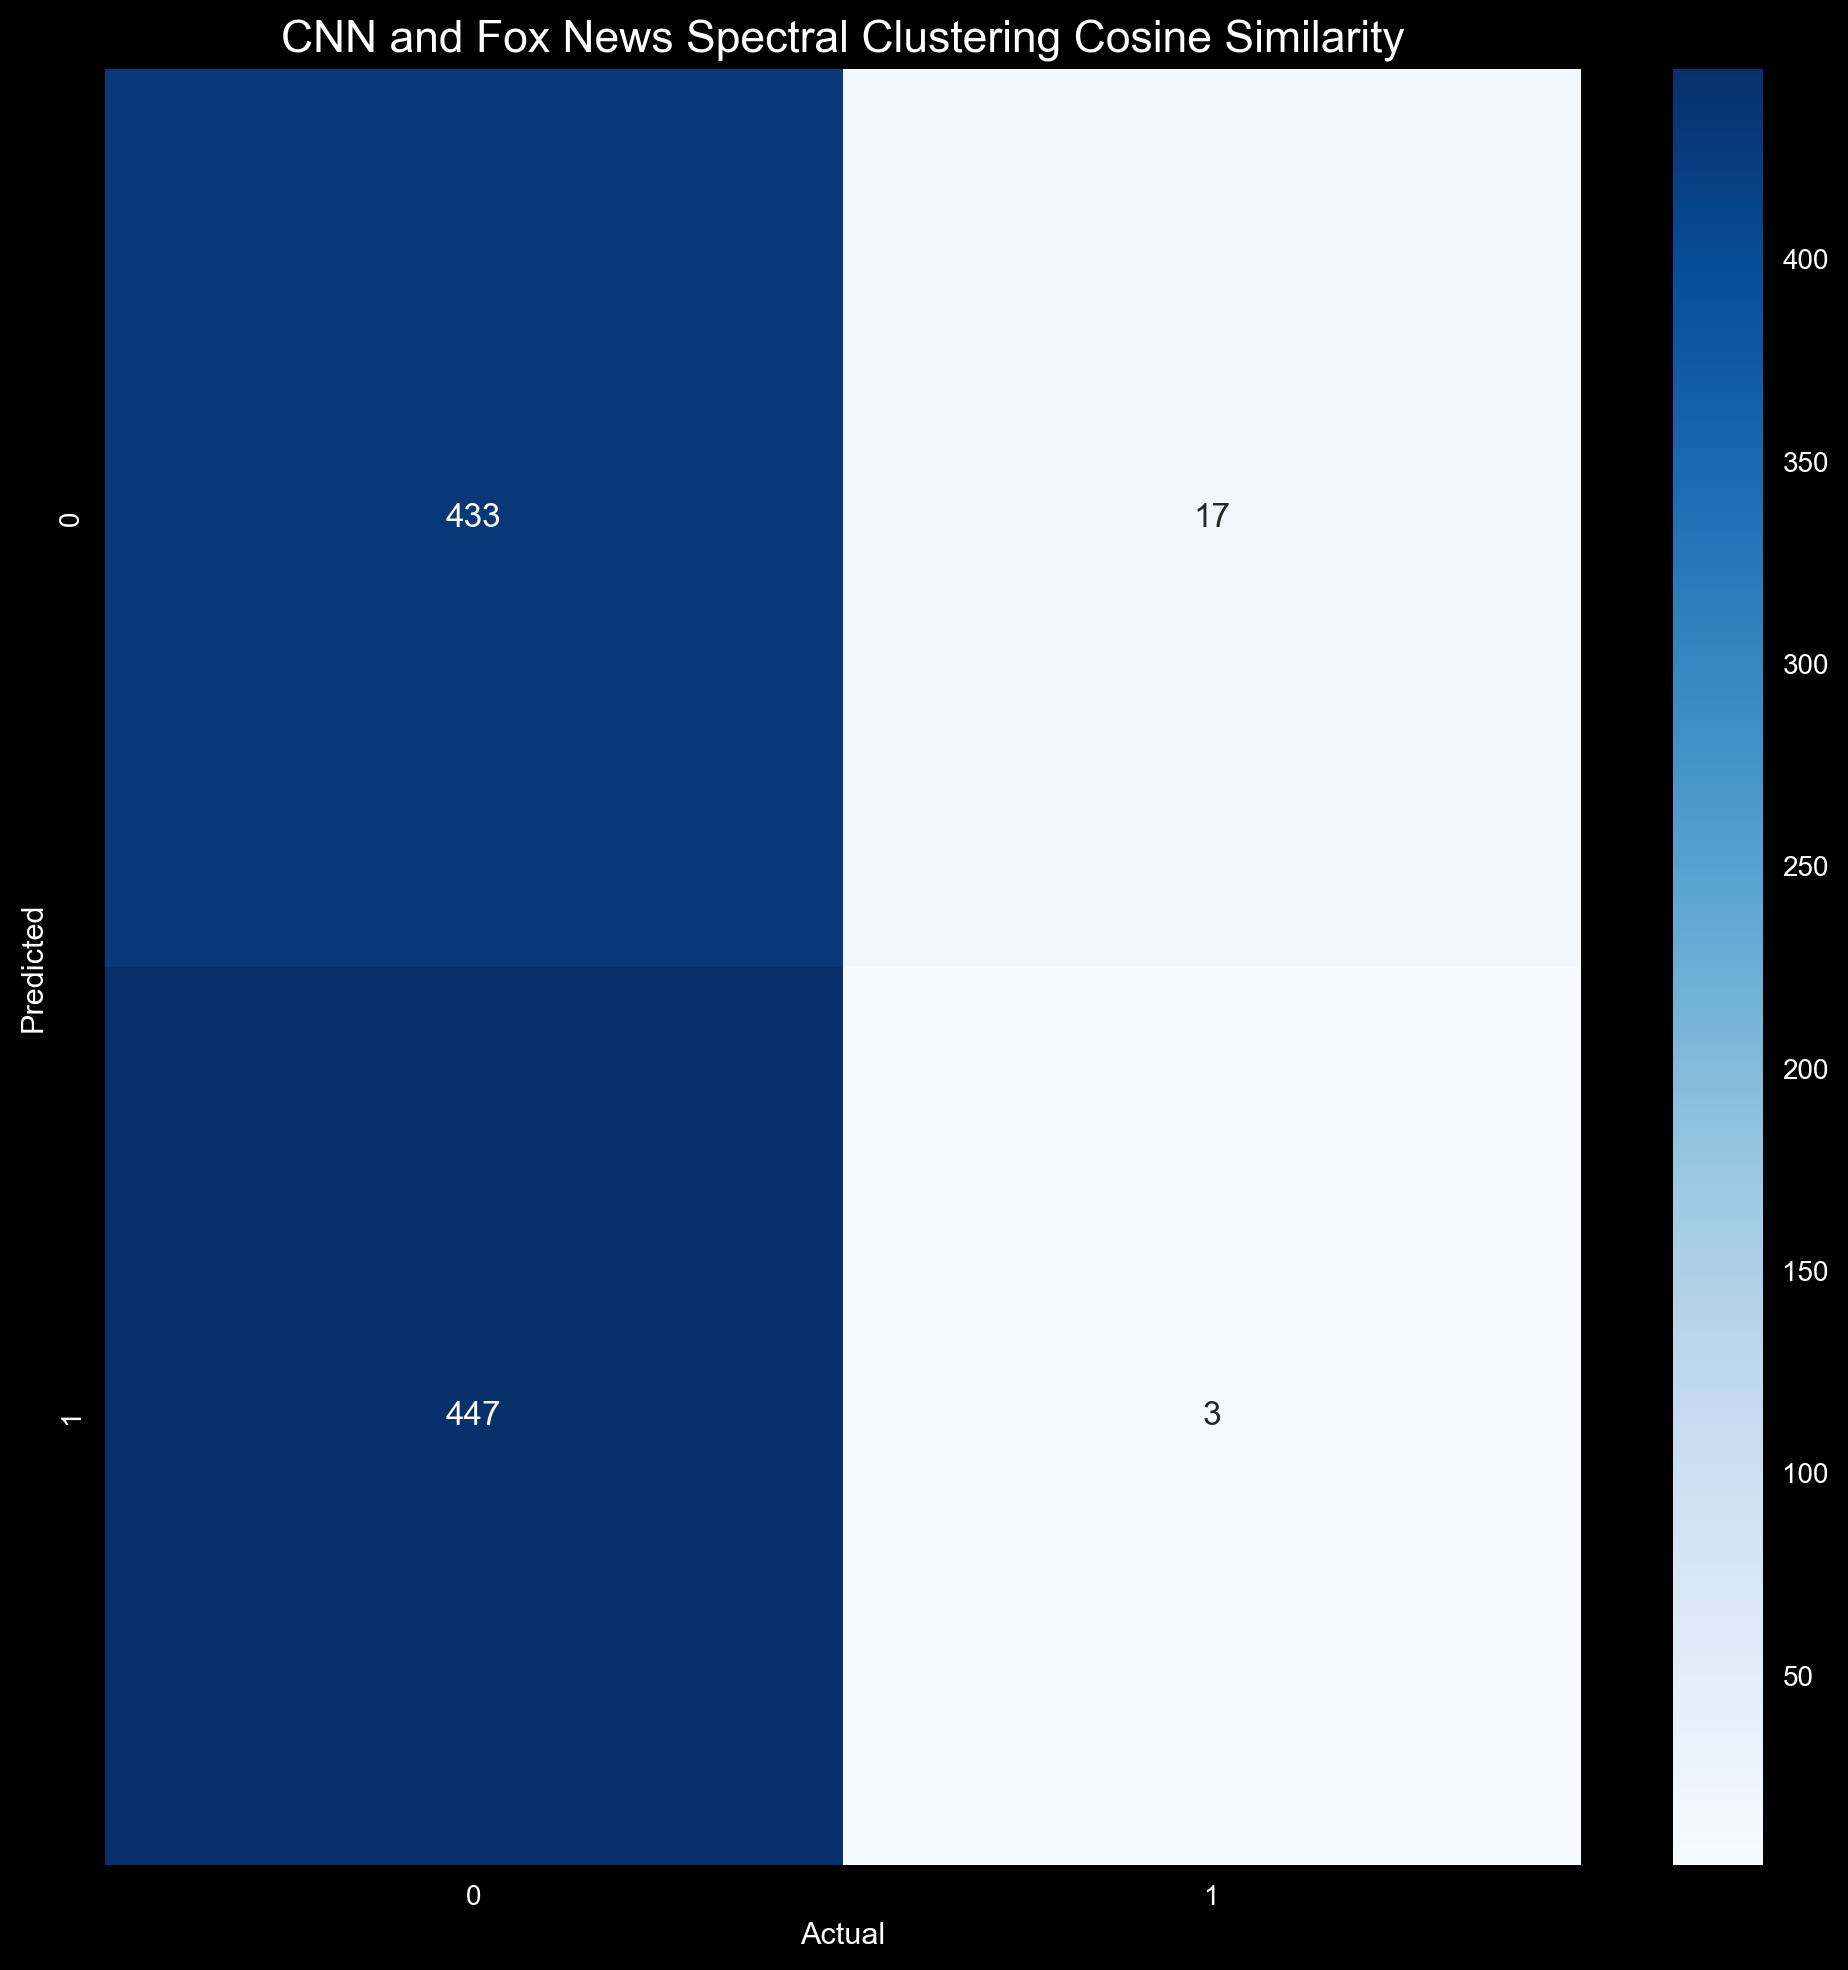

Program Finished! Peace out!


In [52]:
kmeans = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = kmeans.fit_predict(X)
resultsDf['spectral'] = labels

# apply PCA to reduce dimensionality
pca = PCA(2)
pca.fit(np.asarray(X.todense()))
X_pca = pca.transform(np.asarray(X.todense()))

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=resultsDf['source_num'], s=50, cmap='bwr') 
plt.title('Actual', size=20)
plt.text(-0.1, 0.1, 'CNN', size=20)
plt.text(0.1, -0.1, 'Fox News', size=20)
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='bwr')
plt.title('Predicted', size=20)
plt.text(-0.1, 0.1, 'CNN', size=20)
plt.text(0.1, -0.1, 'Fox News', size=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(resultsDf['source_num'], resultsDf['spectral']), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('CNN and Fox News Spectral Clustering Cosine Similarity', size=16)
plt.tight_layout()
plt.show()

print("Program Finished! Peace out!")

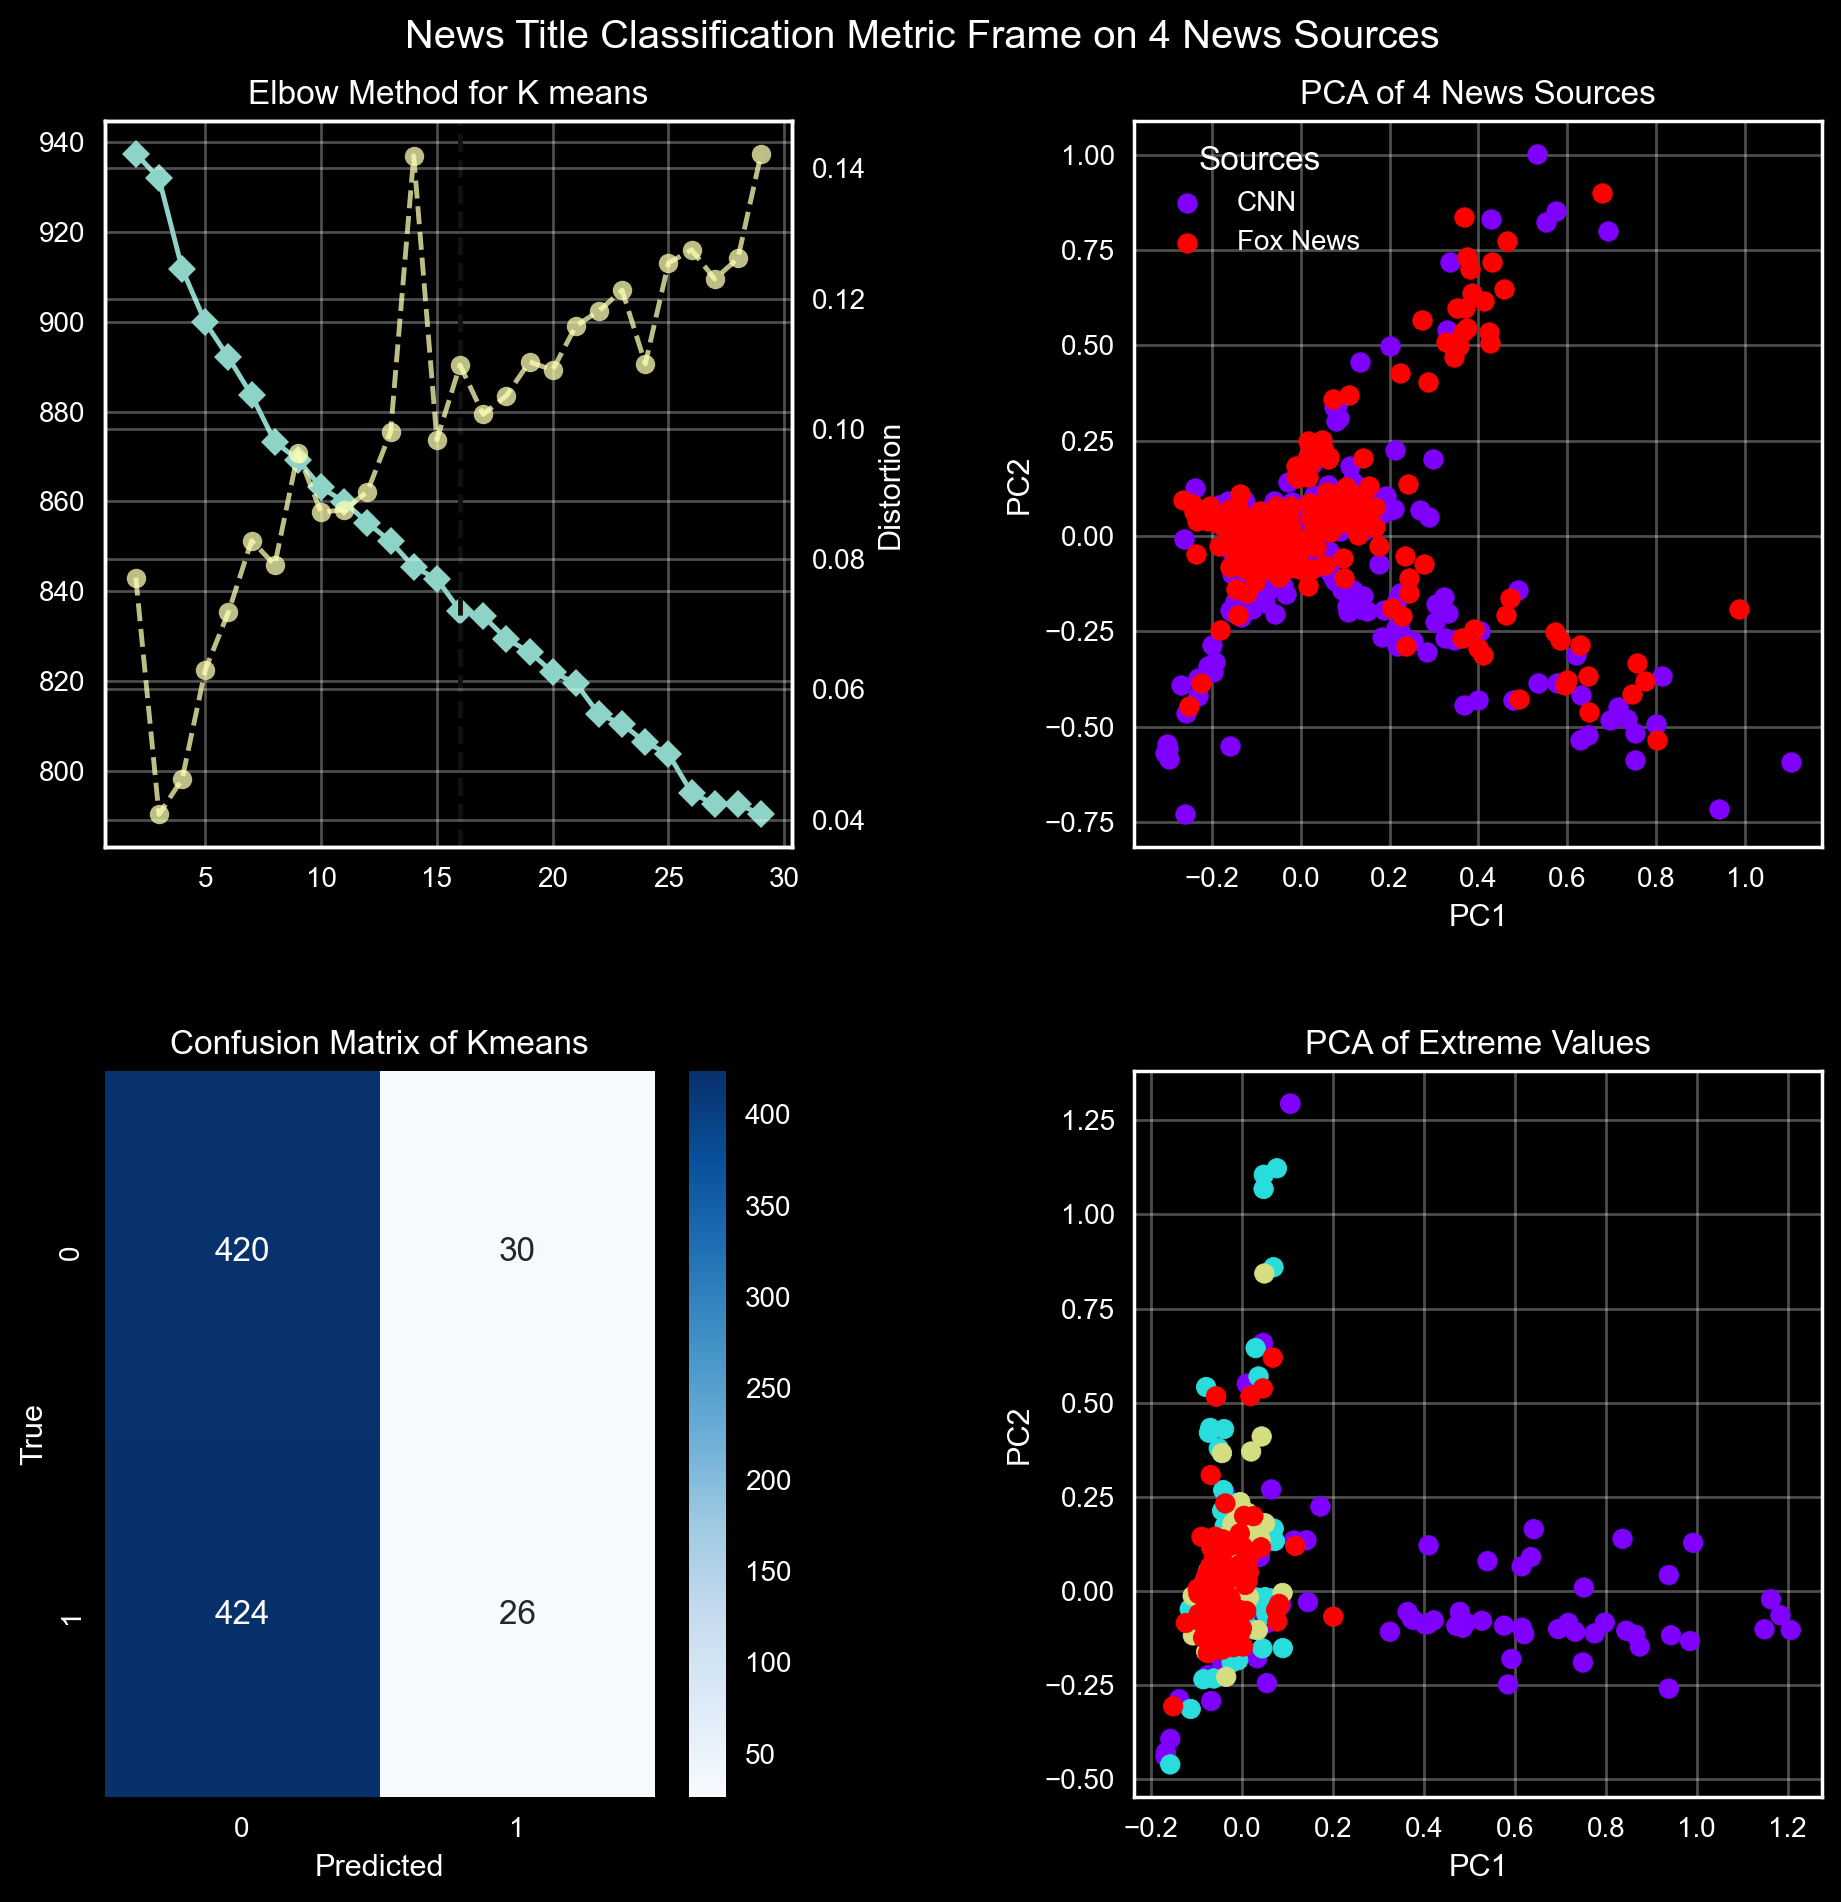

In [7]:
# set plot default for grid decreased alpha
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.style.use('dark_background')

plt.figure(figsize=(10, 10))

# Subplot 1: Elbow Method for K means
plt.subplot(221)

model = SpectralClustering()
visualizer = KElbowVisualizer(model, k=(2,30), timings=True)
visualizer.fit(cosine_similarities_extremes)
plt.title('Elbow Method for K means')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')



# Subplot 2: PCA Scatter Plot
plt.subplot(222)
pca_transformed = PCA(n_components=2).fit_transform(cosine_similarities)
cmap = plt.cm.get_cmap('rainbow', len(keep))
for i, source in enumerate(keep):
    plt.scatter(pca_transformed[documents['source_num'] == i, 0], 
                pca_transformed[documents['source_num'] == i, 1], 
                color=cmap(i), 
                label=source)
plt.title('PCA of 4 News Sources')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="Sources")

# Subplot 3: Confusion Matrix of Kmeans
plt.subplot(223)
sns.heatmap(confusion_matrix(resultsDf['source_num'], resultsDf['kmeans']), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Kmeans')
plt.xlabel('Predicted')
plt.ylabel('True')

# Subplot 4: PCA Scatter Plot of Extreme Values
plt.subplot(224)
pca_transformed_extremes = PCA(n_components=2).fit_transform(cosine_similarities_extremes)
scatter_extremes = plt.scatter(pca_transformed_extremes[:, 0], pca_transformed_extremes[:, 1], c=extremes['source_num'], cmap='rainbow')
plt.title('PCA of Extreme Values')
plt.xlabel('PC1')
plt.ylabel('PC2')



plt.tight_layout(pad=3.0)
plt.suptitle('News Title Classification Metric Frame on 4 News Sources')
plt.show()

### Enhanced Textual Embeddings and Advanced Clustering Methods
In this section, we will enhance the textual embeddings by using transformer-based embeddings such as BERT. Additionally, we will explore more complex clustering algorithms such as DBSCAN and Hierarchical Clustering.

In [202]:
keep = [
        'CNN',
        'Associated Press',
        'Newsweek',
        'Fox News'
        ]
documents, documents_unfiltered, political_orientation = load_data(keep)
display(political_orientation)
display(documents.head())
documents['source'].value_counts()

Data Preprocessing initialized. Will take a few minutes... Please Wait...


{'CNN': 1, 'Associated Press': 2, 'Newsweek': 3, 'Fox News': 4}

source                                              title  \
0  Associated Press  California Sen. Feinstein says she won't run f...   
1  Associated Press  Fox hosts didn’t believe 2020 election fraud c...   
2  Associated Press      Subpoena could set up fight over privilege...   
3  Associated Press  Pence says he will fight subpoena all the way ...   
4  Associated Press  Schools become flashpoint for Republicans eyei...   

                                         description  \
0  Democratic Sen. Dianne Feinstein is not seekin...   
1  Hosts at Fox News had serious concerns about a...   
2  Subpoena could set up fight over privilege...\...   
3  CEDAR RAPIDS, Iowa (AP) — Former Vice Presiden...   
4  Former President Donald Trump has called for p...   

                                      author                publishedAt  \
0  By MICHAEL R. BLOOD - AP Political Writer  2023-02-15 04:22:00+00:00   
1        By RANDALL CHASE - Associated Press  2023-02-17 03:13:00+00:00   
2                                Eric Tucker  2023-02-11 17:46:37+00:00   
3                                    ap news  2023-02-16 03:00:04+00:00   
4    By MICHELLE L. PRICE - Associated Press  2023-02-11 05:30:19+00:00   

                                                 url  sentimentScore    neg  \
0  https://apnews.com/1140a033b78e63687633bc154bc...             0.0  0.000   
1  https://apnews.com/03e8f8f052c69aebbe3f6e07b2e...            -1.0  0.352   
2  https://apnews.com/article/politics-michael-pe...            -1.0  0.321   
3  https://apnews.com/article/us-supreme-court-po...             1.0  0.232   
4  https://apnews.com/c65049b0c64206996dd1bea4cee...             0.0  0.000   

     neu    pos  compound canidate  totalMentions  positive  negative  \
0  1.000  0.000    0.0000      NaN            NaN       NaN       NaN   
1  0.648  0.000   -0.5859      NaN            NaN       NaN       NaN   
2  0.370  0.309   -0.0258      NaN            NaN       NaN       NaN   
3  0.446  0.321    0.2500      NaN            NaN       NaN       NaN   
4  1.000  0.000    0.0000      NaN            NaN       NaN       NaN   

   neutral  source_num  
0      NaN           0  
1      NaN           0  
2      NaN           0  
3      NaN           0  
4      NaN           0

source
Associated Press    200
CNN                 200
Fox News            200
Newsweek            200
Name: count, dtype: int64

In [206]:
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import time

def get_bert_embeddings(texts, tokenizer, model, base=True):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
        outputs = model(**inputs)
        if base:
            embeddings.append(outputs.last_hidden_state.mean(dim=1).detach().numpy())
        else:
            embeddings.append(outputs.logits.detach().numpy())
    return np.vstack(embeddings)

# Load pre-trained BERT model and tokenizer
start = time.time()
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Generate BERT embeddings for the documents
bert_embeddings = get_bert_embeddings(documents['title'].tolist(), bert_tokenizer, bert_model, base=True)
print(f"BERT Base model embeddings generated in {time.time() - start:.2f} seconds")


# Load fine-tuned BERT model and tokenizer
start = time.time()
finetuned_model = AutoModelForSequenceClassification.from_pretrained("chrommium/bert-base-multilingual-cased-finetuned-news-headlines")
finetuned_tokenizer = AutoTokenizer.from_pretrained("chrommium/bert-base-multilingual-cased-finetuned-news-headlines")

# Generate fine-tuned BERT embeddings for the documents
finetuned_bert_embeddings = get_bert_embeddings(documents['title'].tolist(), finetuned_tokenizer, finetuned_model, base=False)
print(f"Fine-tuned BERT embeddings generated in {time.time() - start:.2f} seconds")

Fine-tuned BERT embeddings generated in 113.63 seconds


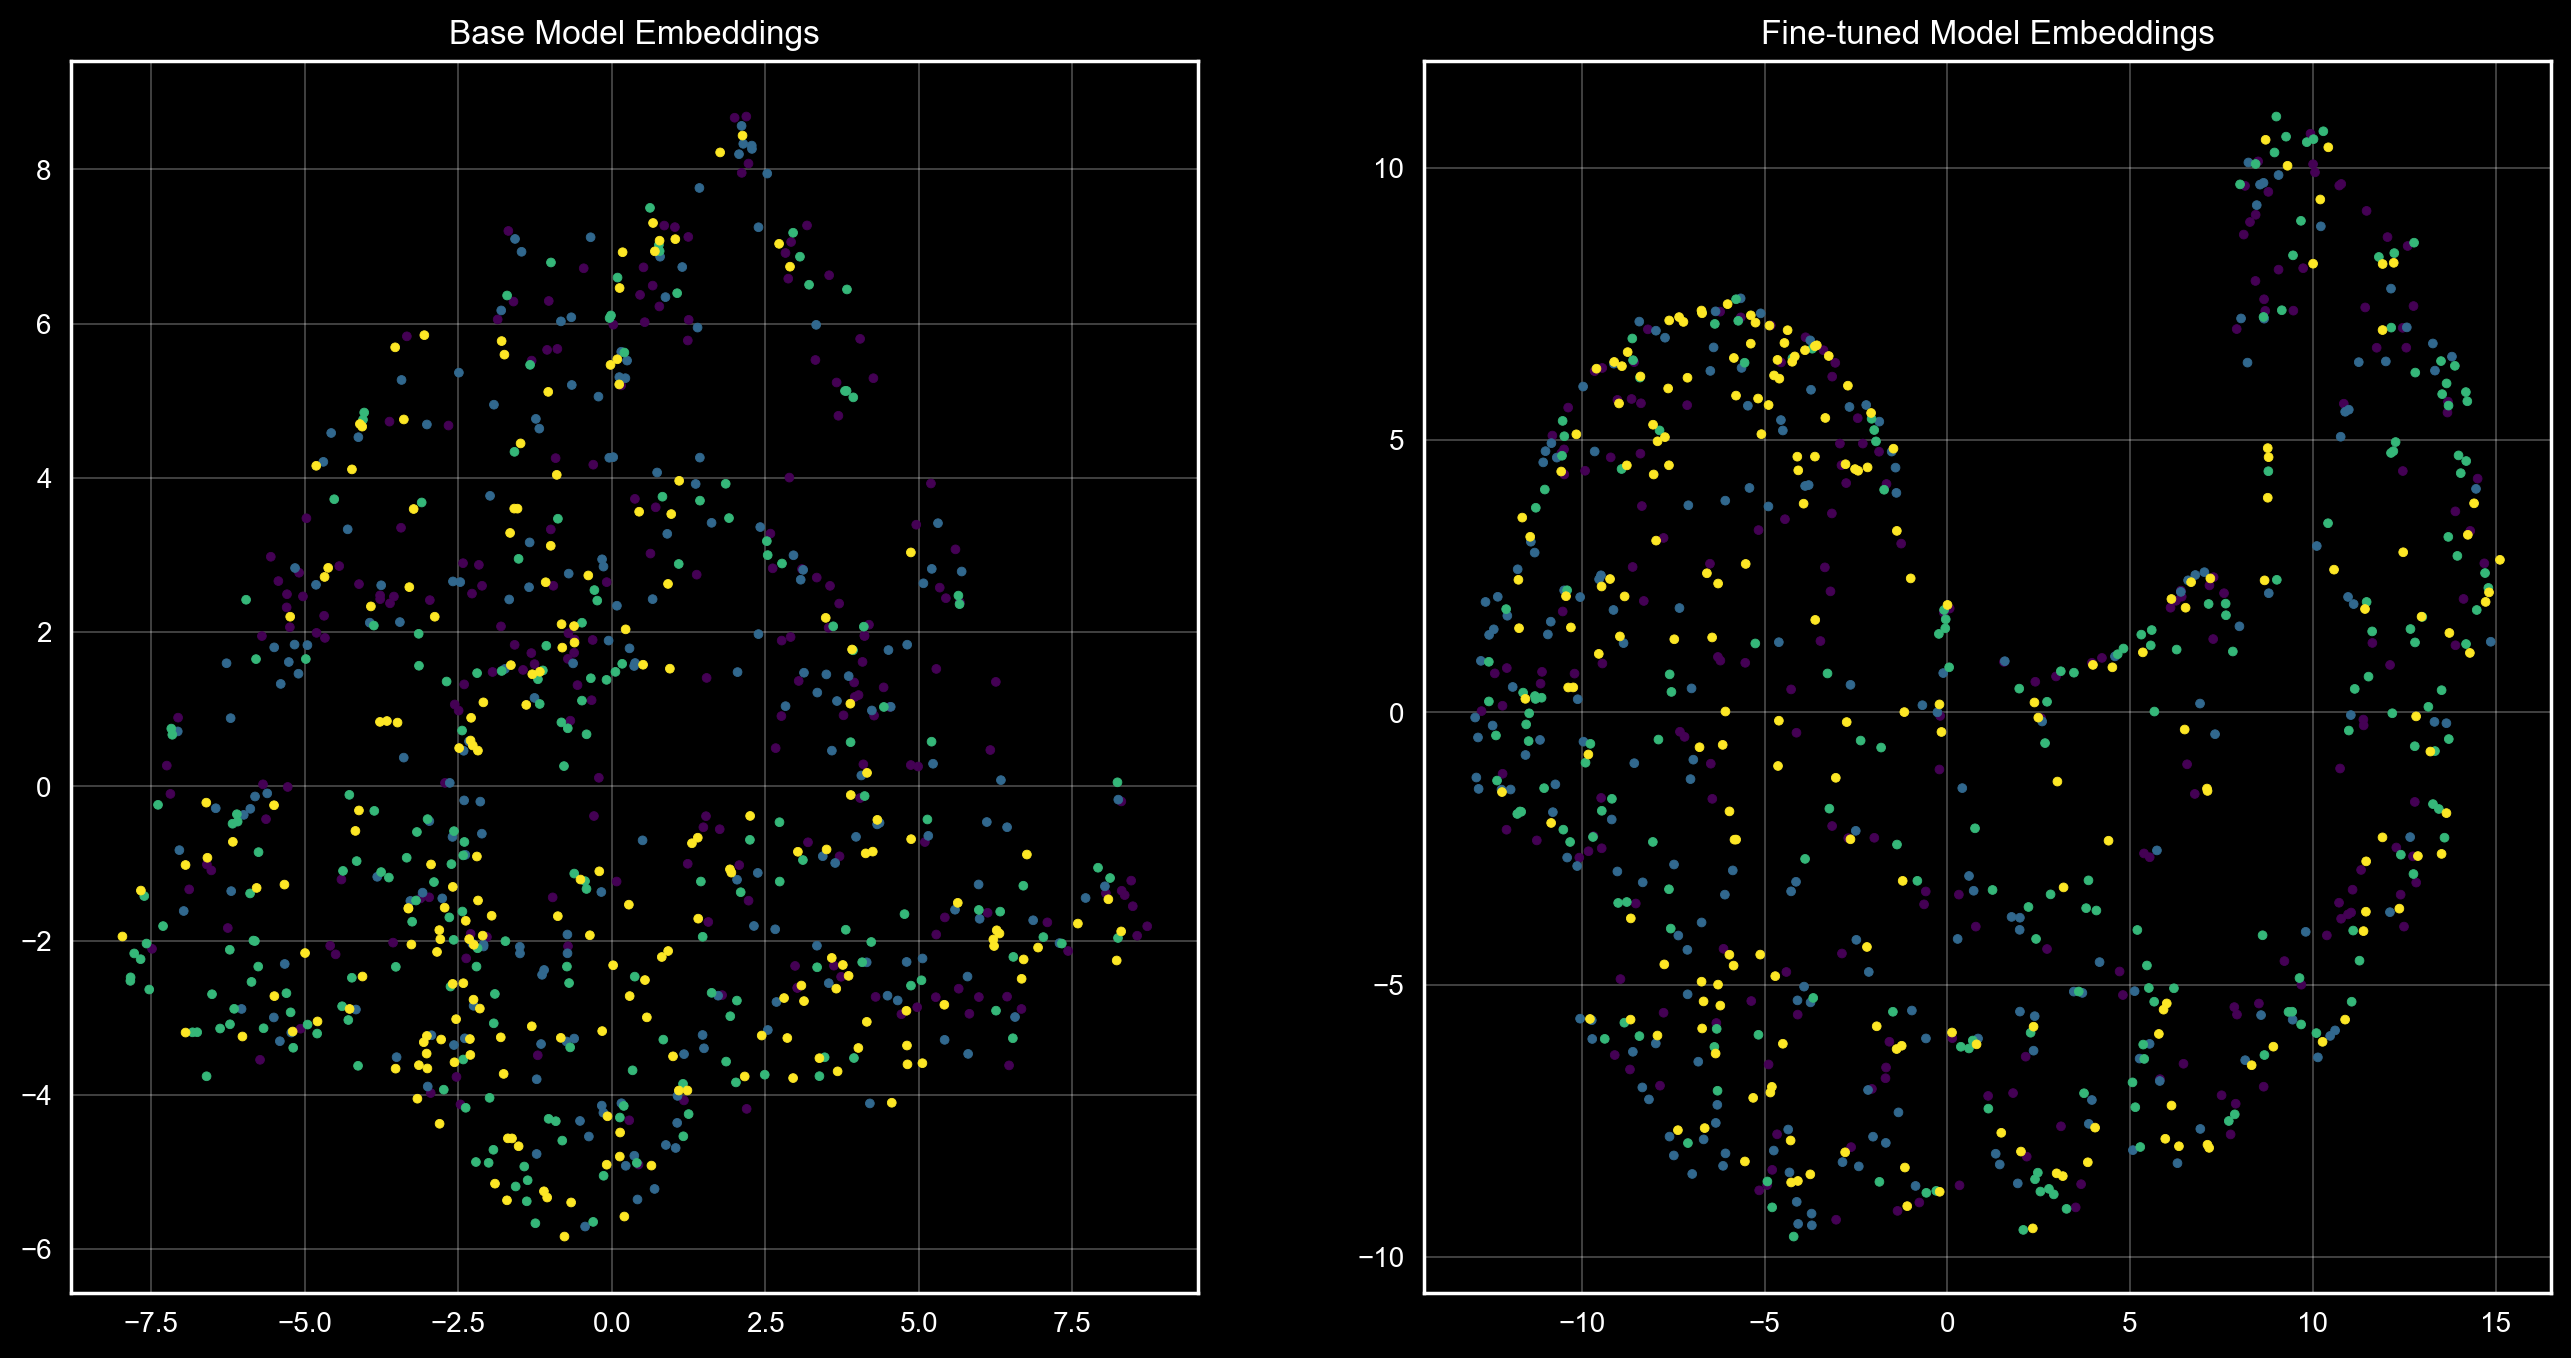

In [212]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Function to plot embeddings
def plot_embeddings(base_embeddings, finetuned_embeddings, labels, n_components=3):
    pca = PCA(n_components=n_components)
    base_pca = pca.fit_transform(base_embeddings)
    finetuned_pca = pca.fit_transform(finetuned_embeddings)
    
    tsne = TSNE(n_components=n_components, random_state=0)
    base_tsne = tsne.fit_transform(base_pca)
    finetuned_tsne = tsne.fit_transform(finetuned_pca)
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.scatter(base_tsne[:, 0], base_tsne[:, 1], c=labels, cmap='viridis', s=10)
    plt.title('Base Model Embeddings')
    
    plt.subplot(1, 2, 2)
    plt.scatter(finetuned_tsne[:, 0], finetuned_tsne[:, 1], c=labels, cmap='viridis', s=10)
    plt.title('Fine-tuned Model Embeddings')
    
    plt.show()

# Assuming 'labels' contains the true labels or cluster assignments for the documents
plot_embeddings(bert_embeddings, finetuned_bert_embeddings, labels)

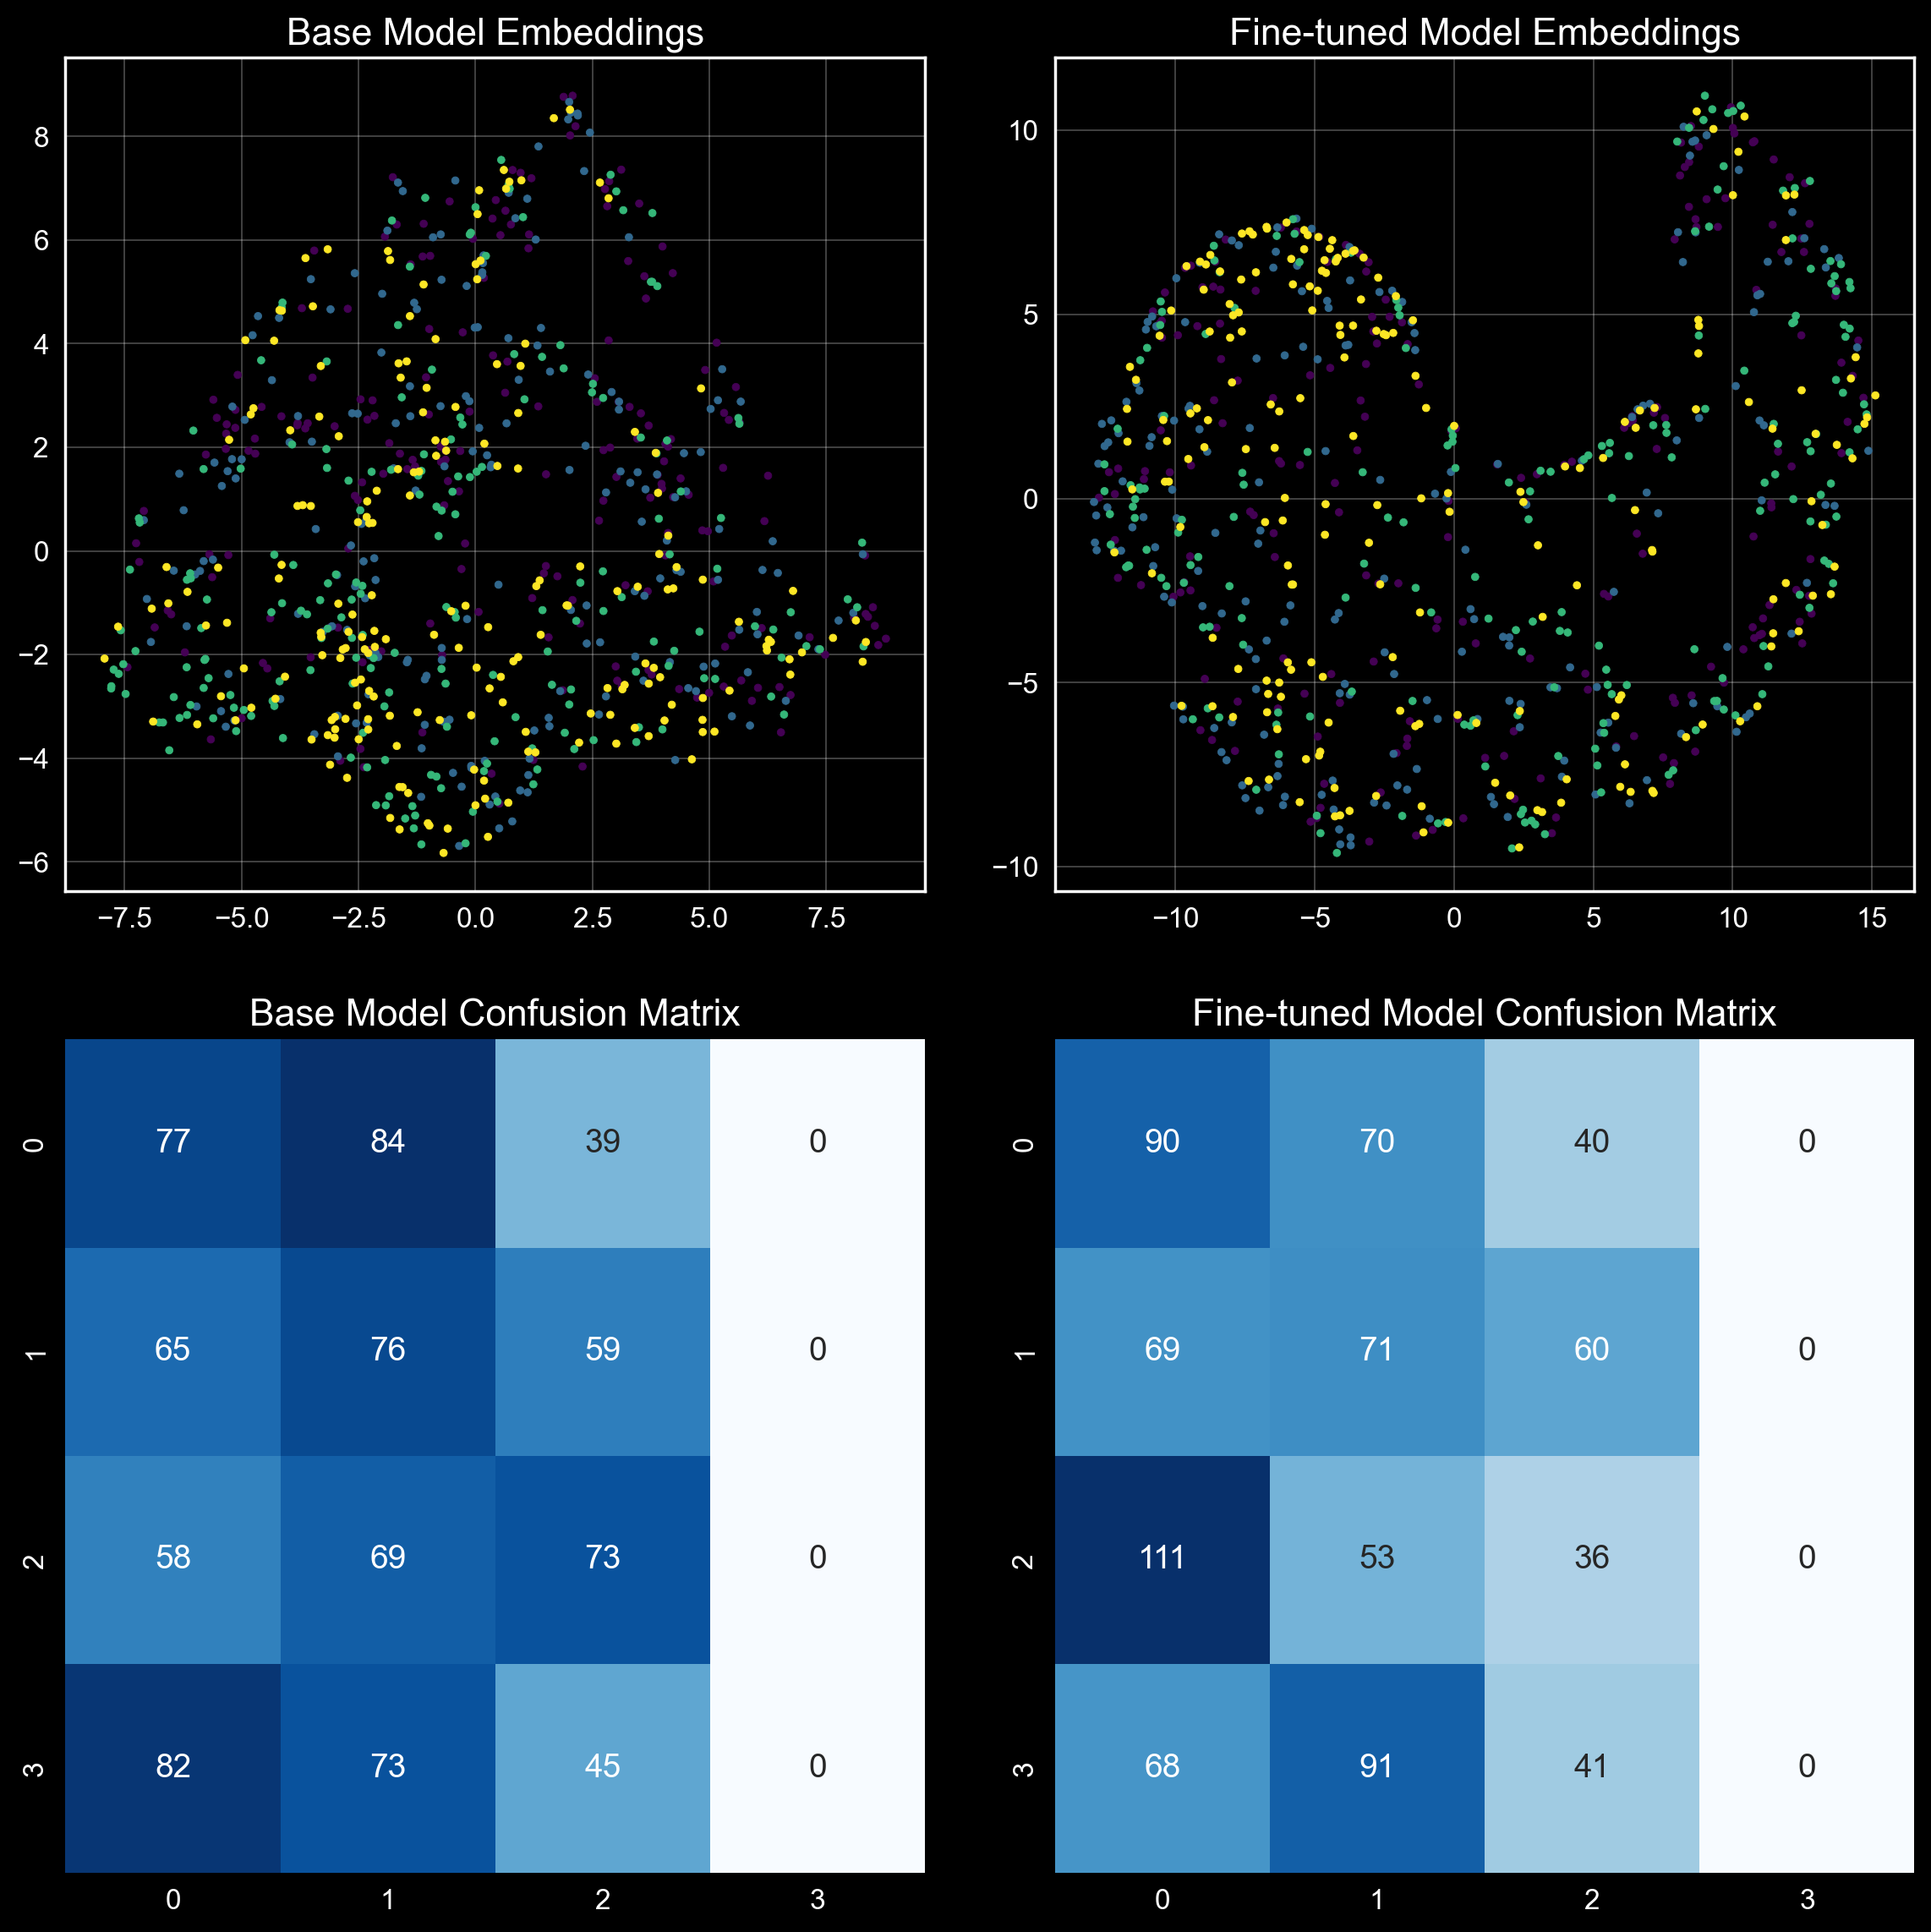

In [217]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

mpl.rcParams.update({
    'font.size': 14,  # Change default font size
    'axes.titlesize': 16,  # Increase title font size
    'axes.labelsize': 14,  # Increase label font size
    'xtick.labelsize': 12,  # Increase x-axis tick label font size
    'ytick.labelsize': 12,  # Increase y-axis tick label font size
})

# Function to plot embeddings and confusion matrix
def plot_embeddings_and_confusion_matrix(base_embeddings, finetuned_embeddings, labels, n_components=3):
    pca = PCA(n_components=n_components)
    base_pca = pca.fit_transform(base_embeddings)
    finetuned_pca = pca.fit_transform(finetuned_embeddings)
    
    tsne = TSNE(n_components=n_components, random_state=0)
    base_tsne = tsne.fit_transform(base_pca)
    finetuned_tsne = tsne.fit_transform(finetuned_pca)
    
    plt.figure(figsize=(12, 12))
    
    plt.subplot(2, 2, 1)
    plt.scatter(base_tsne[:, 0], base_tsne[:, 1], c=labels, cmap='viridis', s=10)
    plt.title('BERT LLM Base Model Embeddings')
    
    plt.subplot(2, 2, 2)
    plt.scatter(finetuned_tsne[:, 0], finetuned_tsne[:, 1], c=labels, cmap='viridis', s=10)
    plt.title('Fine-tuned BERT LLM Model Embeddings')
        
    # Compute confusion matrix for base model
    base_cm = confusion_matrix(labels, base_tsne.argmax(axis=1))
    plt.subplot(2, 2, 3)
    sns.heatmap(base_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Base Confusion Matrix')

    # Compute confusion matrix for fine-tuned model
    finetuned_cm = confusion_matrix(labels, finetuned_tsne.argmax(axis=1))
    plt.subplot(2, 2, 4)
    sns.heatmap(finetuned_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Fine-tuned Model Confusion Matrix')
        
    
    plt.tight_layout(pad=2)
    plt.show()
    


plot_embeddings_and_confusion_matrix(bert_embeddings, finetuned_bert_embeddings, labels)


Data Preprocessing initialized. Will take a few minutes... Please Wait...
Data Preprocessing initialized. Will take a few minutes... Please Wait...


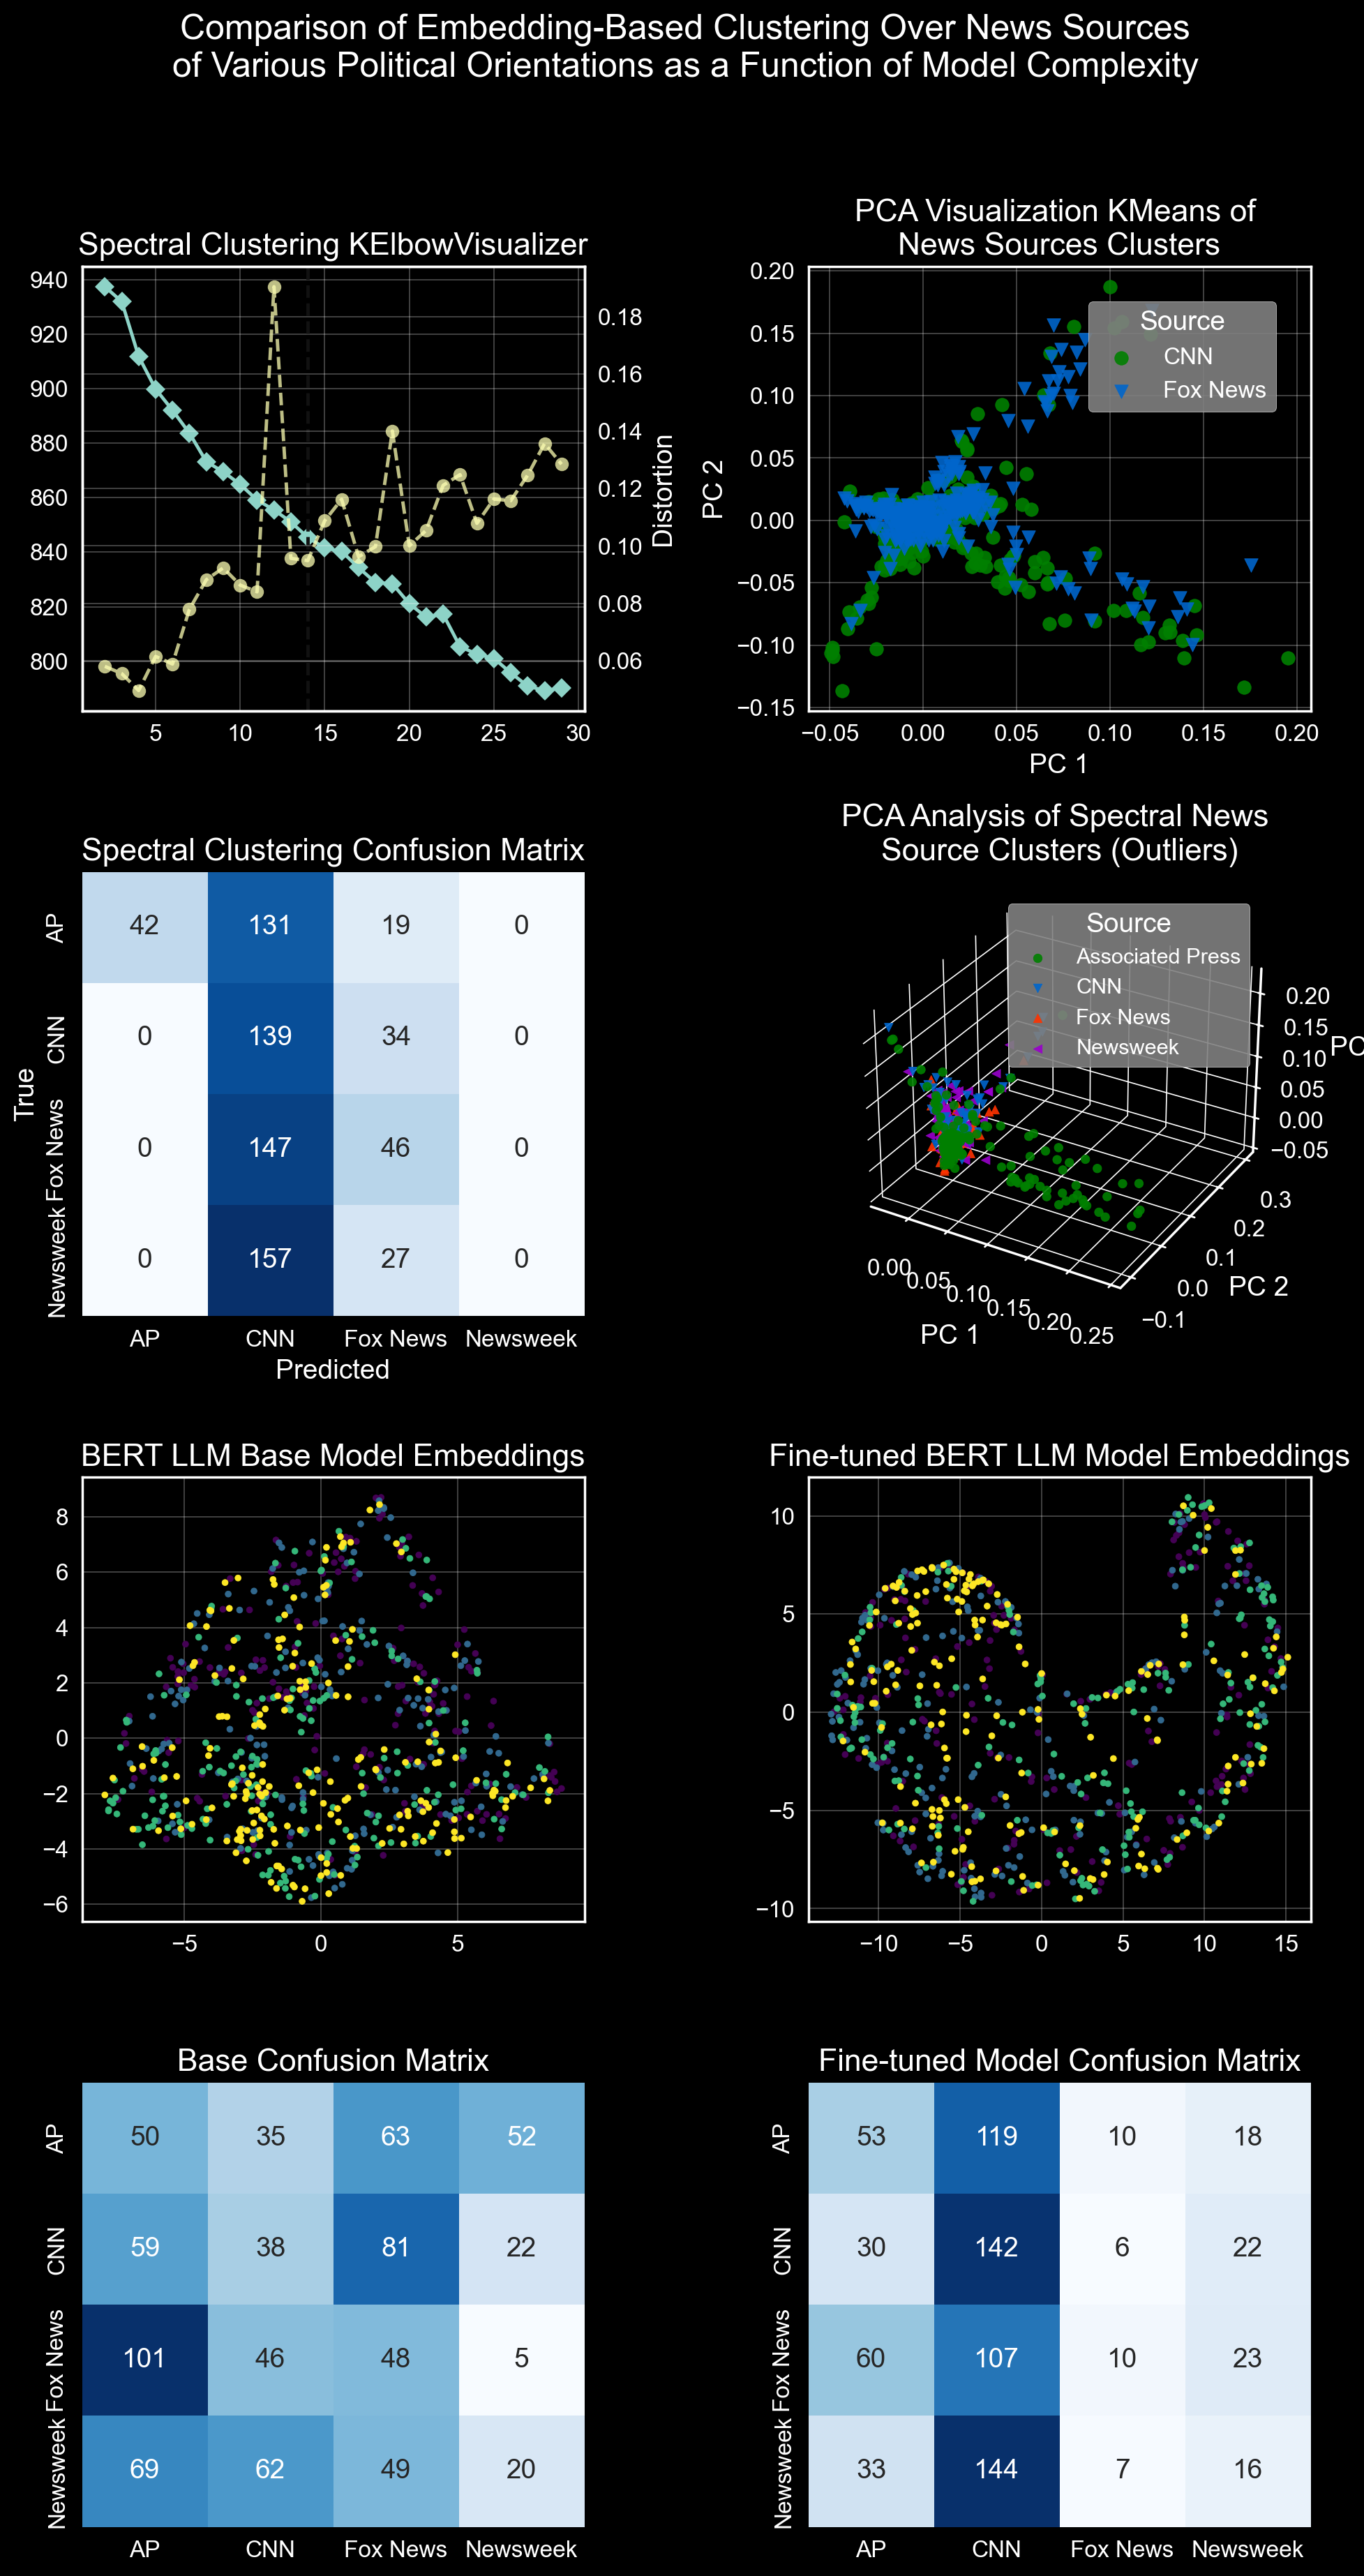

In [314]:

fig = plt.figure(figsize=(10, 18))

load_session_variables()

mpl.rcParams.update({
    'font.size': 14,  # Change default font size
    'axes.titlesize': 16,  # Increase title font size
    'axes.labelsize': 14,  # Increase label font size
    'xtick.labelsize': 12,  # Increase x-axis tick label font size
    'ytick.labelsize': 12,  # Increase y-axis tick label font size
})

# First subplot
plt.subplot(421)
model = SpectralClustering()
visualizer = KElbowVisualizer(model, k=(2,30), timings=True)
visualizer.fit(cosine_similarities_extremes)
plt.title('Spectral Clustering KElbowVisualizer')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')

# Second subplot
plt.subplot(422)
colors = ['green', '#0066cc', '#ff3300', '#9900cc']
markers = ['o', 'v', '^', '<']
pca = PCA(10)
pca.fit(cosine_similarities)
for i, source in enumerate(documents['source'].unique()):
    plt.scatter(pca.components_[0][documents['source_num'] == i], 
                pca.components_[1][documents['source_num'] == i], 
                color=colors[i], 
                marker=markers[i],  
                label=source,
                alpha=0.9)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Visualization KMeans of \nNews Sources Clusters')
plt.legend(loc='upper right', borderaxespad=1.5, frameon=True, title='Source', facecolor='gray', framealpha=0.9, fontsize=12)
plt.tight_layout()

plt.subplot(423)
source_mapping = {0: 'AP', 1: 'CNN', 2: 'Fox News', 3: 'Newsweek'}
heatmap = sns.heatmap(confusion_matrix(extremes['source_num'], extremes['kmeans']), annot=True, fmt='d', cmap='Blues',cbar=False)
heatmap.set_xticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_xticklabels()])
heatmap.set_yticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_yticklabels()])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Spectral Clustering Confusion Matrix')


# Fourth subplot
keep = ['CNN', 'Fox News']
documents, documents_unfiltered, political_orientation = load_data(keep)
labels = documents['source_num'].values

ax = fig.add_subplot(424, projection='3d', facecolor='black', )
ax.grid(color='black', linestyle='-',  alpha=0.2)  # Reduced alpha for grid lines
tf_idf_extremes = featureExtractor.gen_term_matrix(corpus_extremes)
cosine_similarities_extremes = modelTraining.get_cosine_sim(tf_idf_extremes)
pca = PCA(n_components=10)
pca.fit(cosine_similarities_extremes)
for i, source in enumerate(extremes['source'].unique()):
    ax.scatter(pca.components_[0][extremes['source_num'] == i], 
               pca.components_[1][extremes['source_num'] == i], 
               pca.components_[2][extremes['source_num'] == i], 
               color=colors[i], 
               marker=markers[i], 
               label=source,
               alpha=0.9)
ax.set_xlabel('PC 1', labelpad=12)
ax.set_ylabel('PC 2', labelpad=12)
ax.set_zlabel('PC 3', labelpad=12)
ax.set_title('PCA Analysis of Spectral News \nSource Clusters (Outliers)')
ax.legend(loc='upper right', borderaxespad=1.5, frameon=True, title='Source',  framealpha=0.9, fontsize=11,facecolor='gray')

# Update the grid background color to black
ax.xaxis.set_pane_color((0, 0, 0, 1))
ax.yaxis.set_pane_color((0, 0, 0, 1))
ax.zaxis.set_pane_color((0, 0, 0, 1))


keep = [
        'CNN',
        'Associated Press',
        'Newsweek',
        'Fox News']
documents, documents_unfiltered, political_orientation = load_data(keep)

n_components = documents['source_num'].nunique() - 1
labels = documents['source_num'].values

# Reduce dimensions using PCA and t-SNE for visualization
pca = PCA(n_components=n_components)
base_pca = pca.fit_transform(bert_embeddings)
finetuned_pca = pca.fit_transform(finetuned_bert_embeddings)

tsne = TSNE(n_components=n_components, random_state=0)
base_tsne = tsne.fit_transform(base_pca)
finetuned_tsne = tsne.fit_transform(finetuned_pca)

agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_clustering.fit_predict(bert_embeddings_scaled)
documents['agg_base'] = agg_labels

agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_clustering.fit_predict(finetuned_bert_embeddings)
documents['agg_finetuned'] = agg_labels


plt.subplot(425)

plt.scatter(base_tsne[:, 0], base_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.title('BERT LLM Base Model Embeddings')

plt.subplot(426)
plt.scatter(finetuned_tsne[:, 0], finetuned_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.title('Fine-tuned BERT LLM Model Embeddings')
    
# Compute confusion matrix for base model
base_cm = confusion_matrix(labels, base_tsne.argmax(axis=1))
plt.subplot(427)
# heatmap = sns.heatmap(base_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
heatmap = sns.heatmap(confusion_matrix(documents['source_num'], documents['agg_base']), annot=True, fmt='d', cmap='Blues', cbar=False)
heatmap.set_xticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_xticklabels()])
heatmap.set_yticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_yticklabels()])
plt.title('Base Confusion Matrix')

# Eighth subplot
finetuned_cm = confusion_matrix(labels, finetuned_tsne.argmax(axis=1))
plt.subplot(428)
# heatmap = sns.heatmap(finetuned_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
heatmap = sns.heatmap(confusion_matrix(documents['source_num'], documents['agg_finetuned']), annot=True, fmt='d', cmap='Blues', cbar=False)
heatmap.set_xticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_xticklabels()])
heatmap.set_yticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_yticklabels()])
plt.title('Fine-tuned Model Confusion Matrix')

    

plt.suptitle('Comparison of Embedding-Based Clustering Over News Sources\nof Various Political Orientations as a Function of Model Complexity', size=18, y=1.025)
plt.tight_layout(pad=1.0)
plt.show()

In [288]:
plt.rcParams['figure.constrained_layout.use'] = True

Data Preprocessing initialized. Will take a few minutes... Please Wait...
Data Preprocessing initialized. Will take a few minutes... Please Wait...


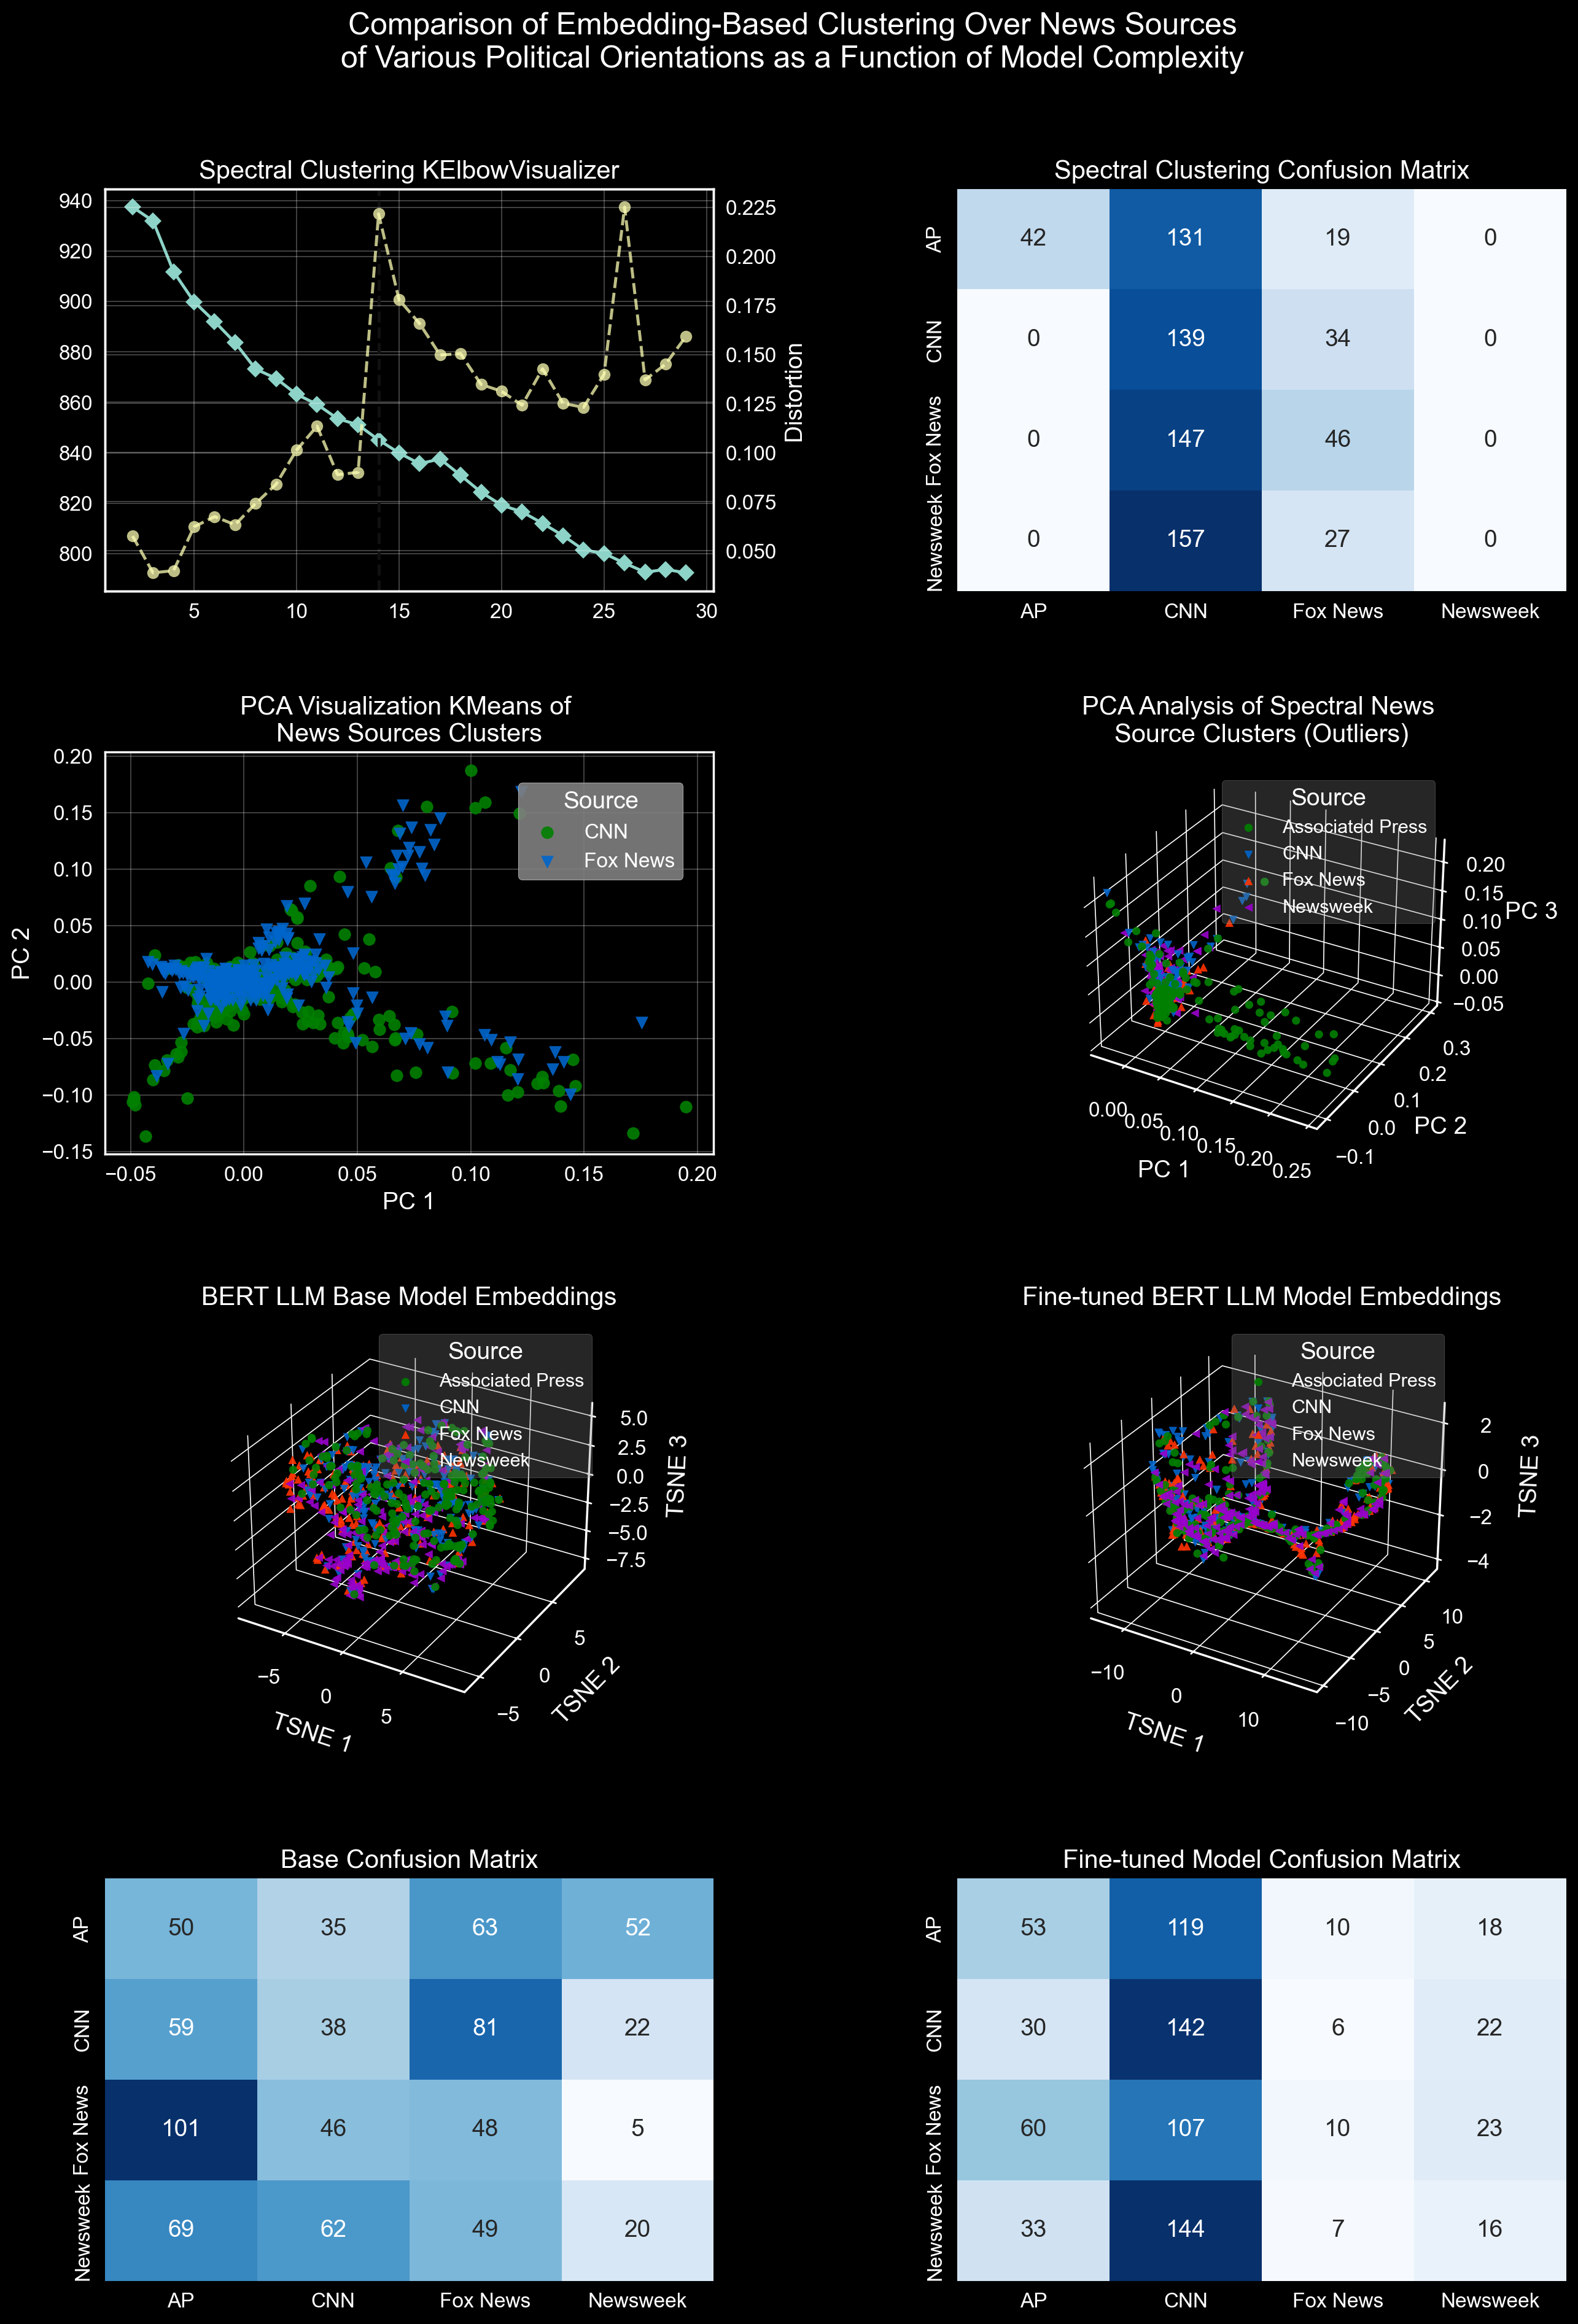

In [307]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 24))

load_session_variables()

mpl.rcParams.update({
    'font.size': 14,  # Change default font size
    'axes.titlesize': 15,  # Increase title font size
    'axes.labelsize': 14,  # Increase label font size
    'xtick.labelsize': 12,  # Increase x-axis tick label font size
    'ytick.labelsize': 12,  # Increase y-axis tick label font size
    'figure.constrained_layout.use': True
})
plt.rcParams['figure.constrained_layout.use'] = True
# First subplot
plt.subplot(421)
model = SpectralClustering()
visualizer = KElbowVisualizer(model, k=(2, 30), timings=True)
visualizer.fit(cosine_similarities_extremes)
plt.title('Spectral Clustering KElbowVisualizer')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')

# Second subplot
plt.subplot(422)
source_mapping = {0: 'AP', 1: 'CNN', 2: 'Fox News', 3: 'Newsweek'}
heatmap = sns.heatmap(confusion_matrix(extremes['source_num'], extremes['kmeans']), annot=True, fmt='d', cmap='Blues', cbar=False)
heatmap.set_xticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_xticklabels()])
heatmap.set_yticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_yticklabels()])
plt.title('Spectral Clustering Confusion Matrix')

# Third subplot
plt.subplot(423)
colors = ['green', '#0066cc', '#ff3300', '#9900cc']
markers = ['o', 'v', '^', '<']
pca = PCA(10)
pca.fit(cosine_similarities)
for i, source in enumerate(documents['source'].unique()):
    plt.scatter(pca.components_[0][documents['source_num'] == i], 
                pca.components_[1][documents['source_num'] == i], 
                color=colors[i], 
                marker=markers[i],  
                label=source,
                alpha=0.9)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Visualization KMeans of \nNews Sources Clusters')
plt.legend(loc='upper right', borderaxespad=1.5, frameon=True, title='Source', facecolor='gray', framealpha=0.9, fontsize=12)
plt.tight_layout()

# Fourth subplot
keep = ['CNN', 'Fox News']
documents, documents_unfiltered, political_orientation = load_data(keep)
labels = documents['source_num'].values

ax = fig.add_subplot(424, projection='3d', facecolor='black')
ax.grid(color='black', linestyle='-', alpha=0.2)  # Reduced alpha for grid lines
tf_idf_extremes = featureExtractor.gen_term_matrix(corpus_extremes)
cosine_similarities_extremes = modelTraining.get_cosine_sim(tf_idf_extremes)
pca = PCA(n_components=10)
pca.fit(cosine_similarities_extremes)
for i, source in enumerate(extremes['source'].unique()):
    ax.scatter(pca.components_[0][extremes['source_num'] == i], 
               pca.components_[1][extremes['source_num'] == i], 
               pca.components_[2][extremes['source_num'] == i], 
               color=colors[i], 
               marker=markers[i], 
               label=source,
               alpha=0.9)
ax.set_xlabel('PC 1', labelpad=12)
ax.set_ylabel('PC 2', labelpad=12)
ax.set_zlabel('PC 3', labelpad=12)
ax.set_title('PCA Analysis of Spectral News \nSource Clusters (Outliers)')
ax.legend(loc='upper right', borderaxespad=1.5, frameon=True, title='Source', framealpha=0.3, fontsize=11, facecolor='gray')

ax.xaxis.set_pane_color((0, 0, 0, 1))
ax.yaxis.set_pane_color((0, 0, 0, 1))
ax.zaxis.set_pane_color((0, 0, 0, 1))

# Fifth and Sixth subplots
keep = [
        'CNN',
        'Associated Press',
        'Newsweek',
        'Fox News']
documents, documents_unfiltered, political_orientation = load_data(keep)

labels = documents['source_num'].values
n_components = documents['source_num'].nunique() - 1

from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
bert_embeddings_scaled = scaler.fit_transform(bert_embeddings)

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(bert_embeddings_scaled)
documents['dbscan'] = dbscan_labels

agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_clustering.fit_predict(bert_embeddings_scaled)
documents['agg_base'] = agg_labels

agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_clustering.fit_predict(finetuned_bert_embeddings)
documents['agg_finetuned'] = agg_labels



# Reduce dimensions using PCA and t-SNE for visualization
pca = PCA(n_components=n_components)
base_pca = pca.fit_transform(bert_embeddings)
finetuned_pca = pca.fit_transform(finetuned_bert_embeddings)

tsne = TSNE(n_components=n_components, random_state=0)
base_tsne = tsne.fit_transform(base_pca)
finetuned_tsne = tsne.fit_transform(finetuned_pca)


agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_clustering.fit_predict(bert_embeddings_scaled)
documents['agg'] = agg_labels

# Fifth subplot updated to 3D
ax = fig.add_subplot(425, projection='3d', facecolor='black')
ax.grid(color='black', linestyle='-', alpha=0.2)  # Reduced alpha for grid lines
for i, source in enumerate(documents['source'].unique()):
    ax.scatter(base_tsne[documents['source_num'] == i, 0], 
               base_tsne[documents['source_num'] == i, 1], 
               base_tsne[documents['source_num'] == i, 2], 
               color=colors[i], 
               marker=markers[i], 
               label=source,
               alpha=0.9)
ax.set_xlabel('TSNE 1', labelpad=12)
ax.set_ylabel('TSNE 2', labelpad=12)
ax.set_zlabel('TSNE 3', labelpad=12)
ax.set_title('BERT LLM Base Model Embeddings')
ax.legend(loc='upper right', borderaxespad=1, frameon=True, title='Source', framealpha=0.3, fontsize=11, facecolor='gray')
ax.xaxis.set_pane_color((0, 0, 0, 1))
ax.yaxis.set_pane_color((0, 0, 0, 1))
ax.zaxis.set_pane_color((0, 0, 0, 1))

# Sixth subplot updated to 3D
ax = fig.add_subplot(426, projection='3d', facecolor='black')
ax.grid(color='black', linestyle='-', alpha=0.2)  # Reduced alpha for grid lines
for i, source in enumerate(documents['source'].unique()):
    ax.scatter(finetuned_tsne[documents['source_num'] == i, 0], 
               finetuned_tsne[documents['source_num'] == i, 1], 
               finetuned_tsne[documents['source_num'] == i, 2], 
               color=colors[i], 
               marker=markers[i], 
               label=source,
               alpha=0.9)
ax.set_xlabel('TSNE 1', labelpad=12)
ax.set_ylabel('TSNE 2', labelpad=12)
ax.set_zlabel('TSNE 3', labelpad=12)
ax.set_title('Fine-tuned BERT LLM Model Embeddings')
ax.legend(loc='upper right', borderaxespad=1, frameon=True, title='Source', framealpha=0.3, fontsize=11, facecolor='gray')
ax.xaxis.set_pane_color((0, 0, 0, 1))
ax.yaxis.set_pane_color((0, 0, 0, 1))
ax.zaxis.set_pane_color((0, 0, 0, 1))

# Seventh subplot
base_cm = confusion_matrix(labels, base_tsne.argmax(axis=1))
plt.subplot(427)
heatmap = sns.heatmap(confusion_matrix(documents['source_num'], documents['agg_base']), annot=True, fmt='d', cmap='Blues', cbar=False)
heatmap.set_xticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_xticklabels()])
heatmap.set_yticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_yticklabels()])
plt.title('Base Confusion Matrix')

# Eighth subplot
finetuned_cm = confusion_matrix(labels, finetuned_tsne.argmax(axis=1))
plt.subplot(428)
heatmap = sns.heatmap(confusion_matrix(documents['source_num'], documents['agg_finetuned']), annot=True, fmt='d', cmap='Blues', cbar=False)
heatmap.set_xticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_xticklabels()])
heatmap.set_yticklabels([source_mapping[int(label.get_text())] for label in heatmap.get_yticklabels()])
plt.title('Fine-tuned Model Confusion Matrix')

plt.suptitle('Comparison of Embedding-Based Clustering Over News Sources\nof Various Political Orientations as a Function of Model Complexity', size=18, x=0.45, y=.92)
plt.tight_layout(pad=1.5)
plt.subplots_adjust(left=0.05, right=0.9, bottom=0.15, top=0.86, wspace=0.4, hspace=0.4)

plt.show()

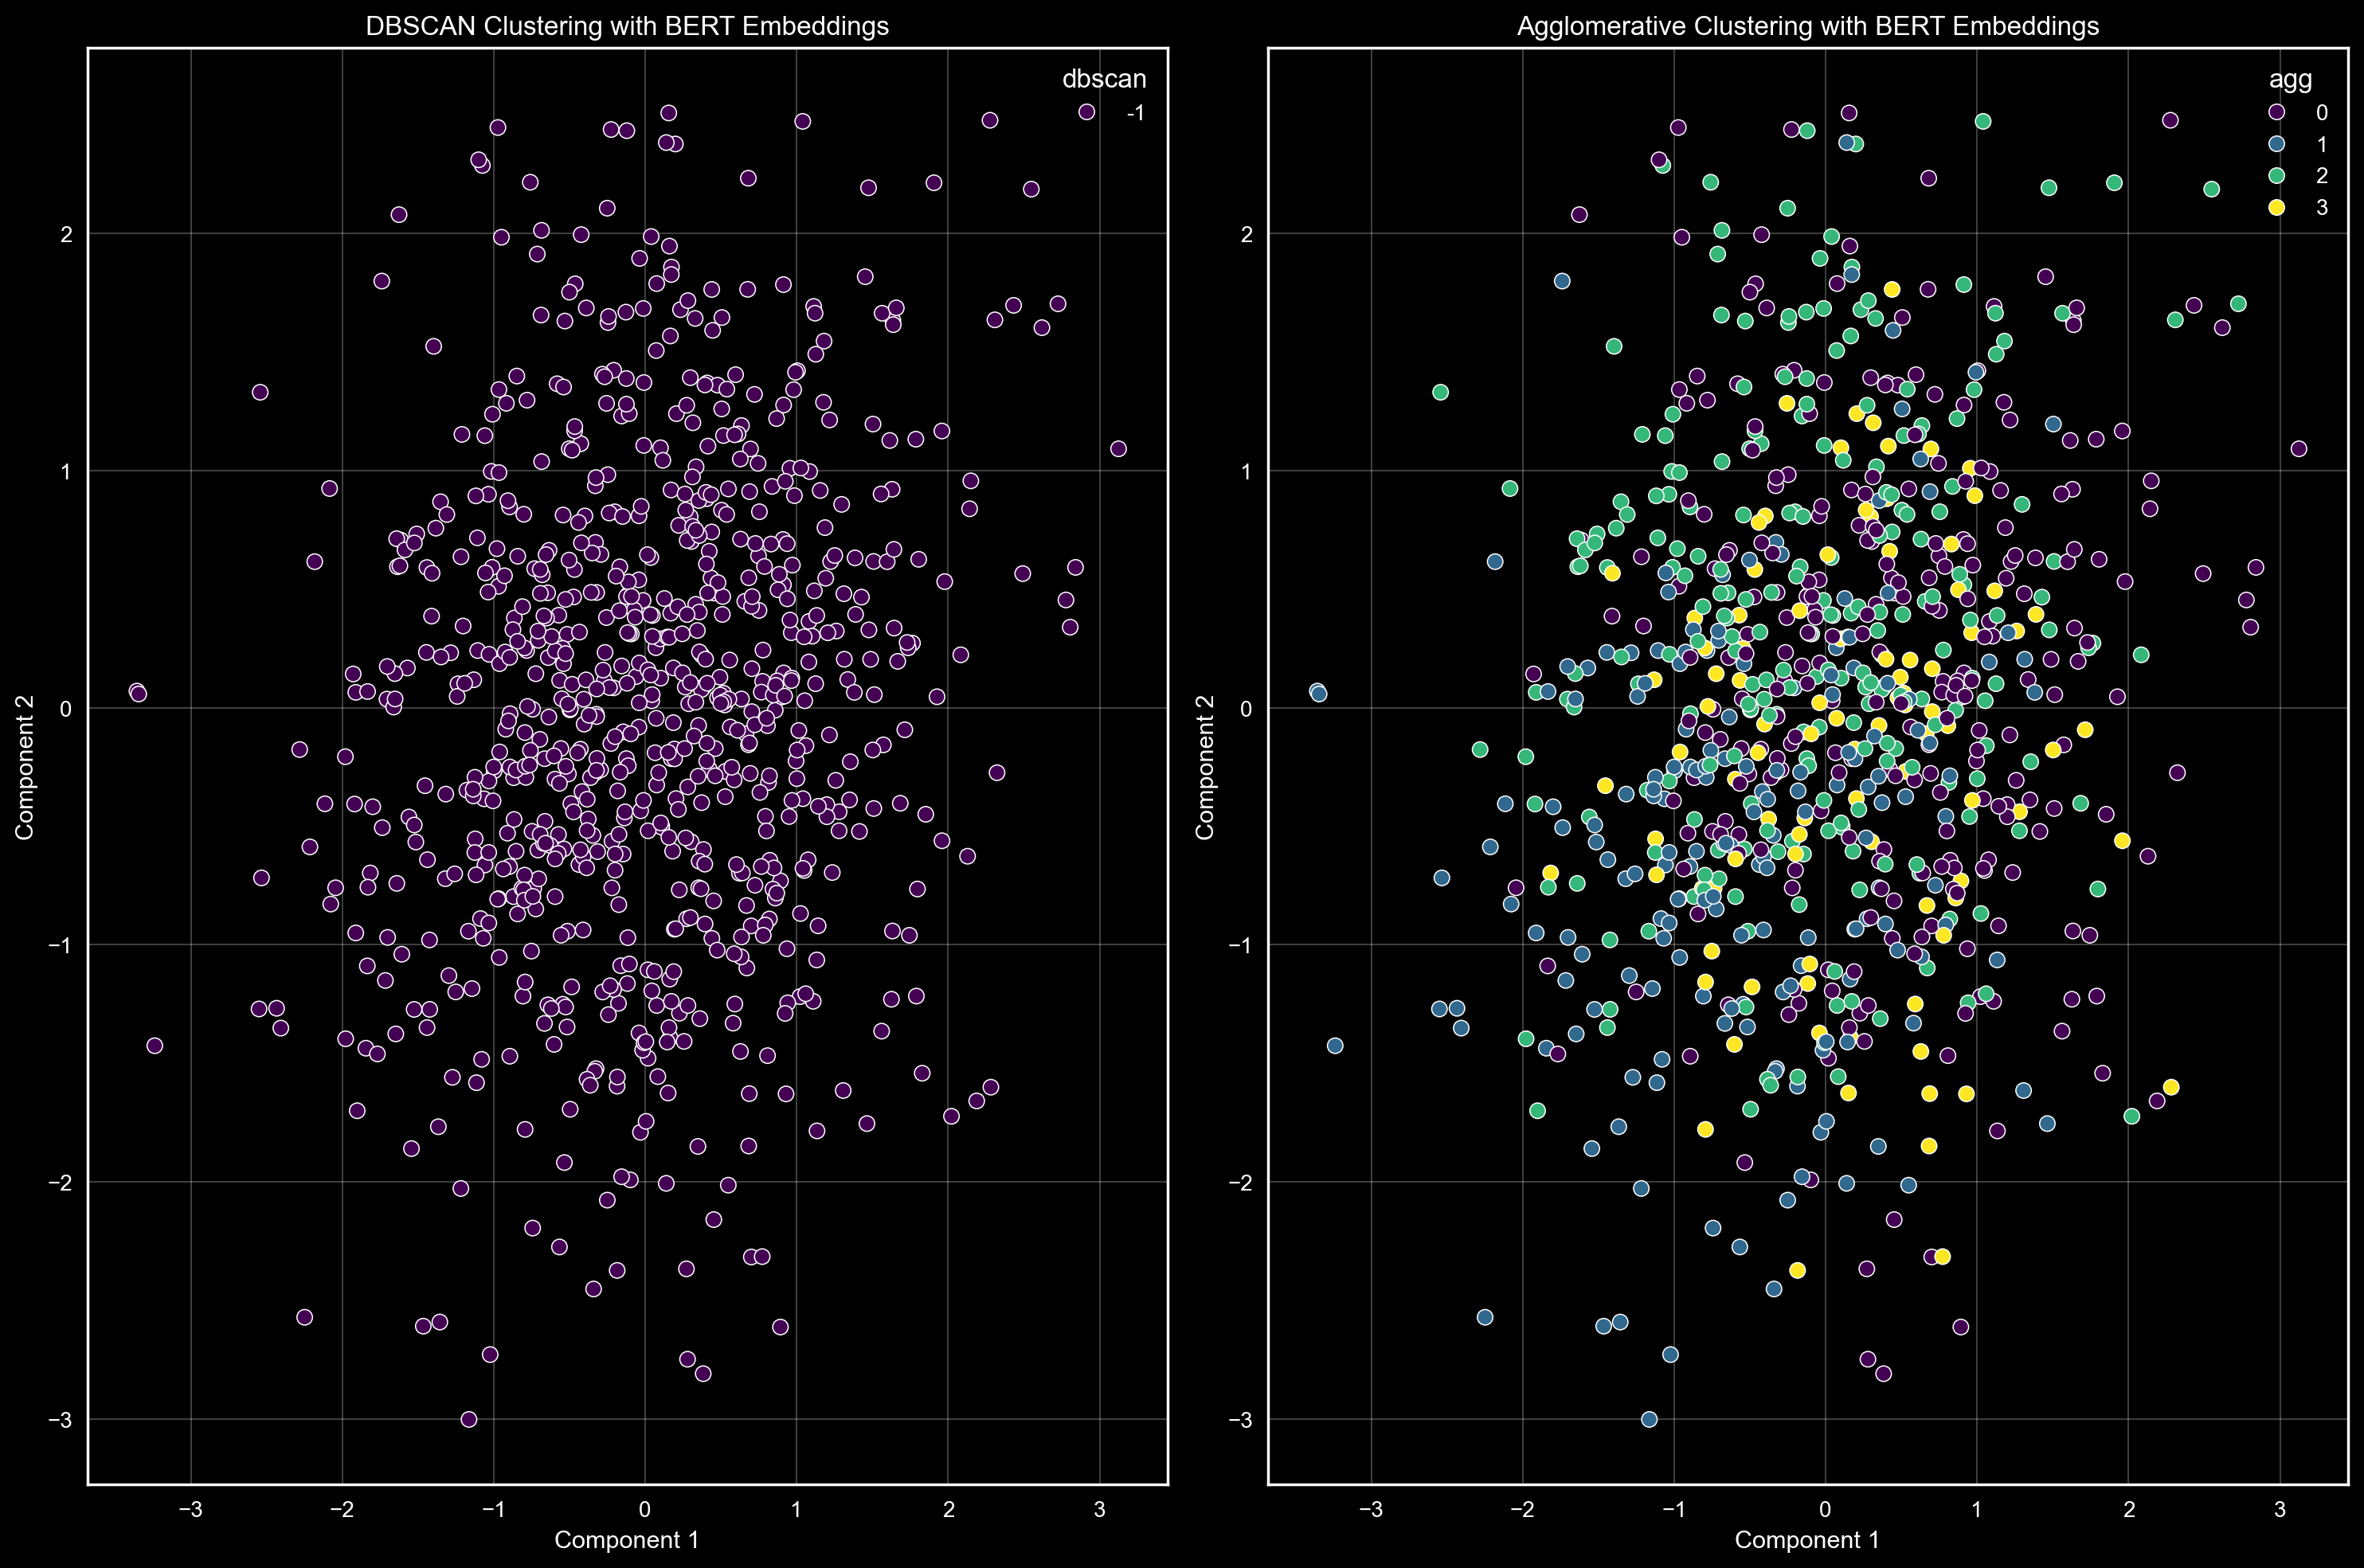

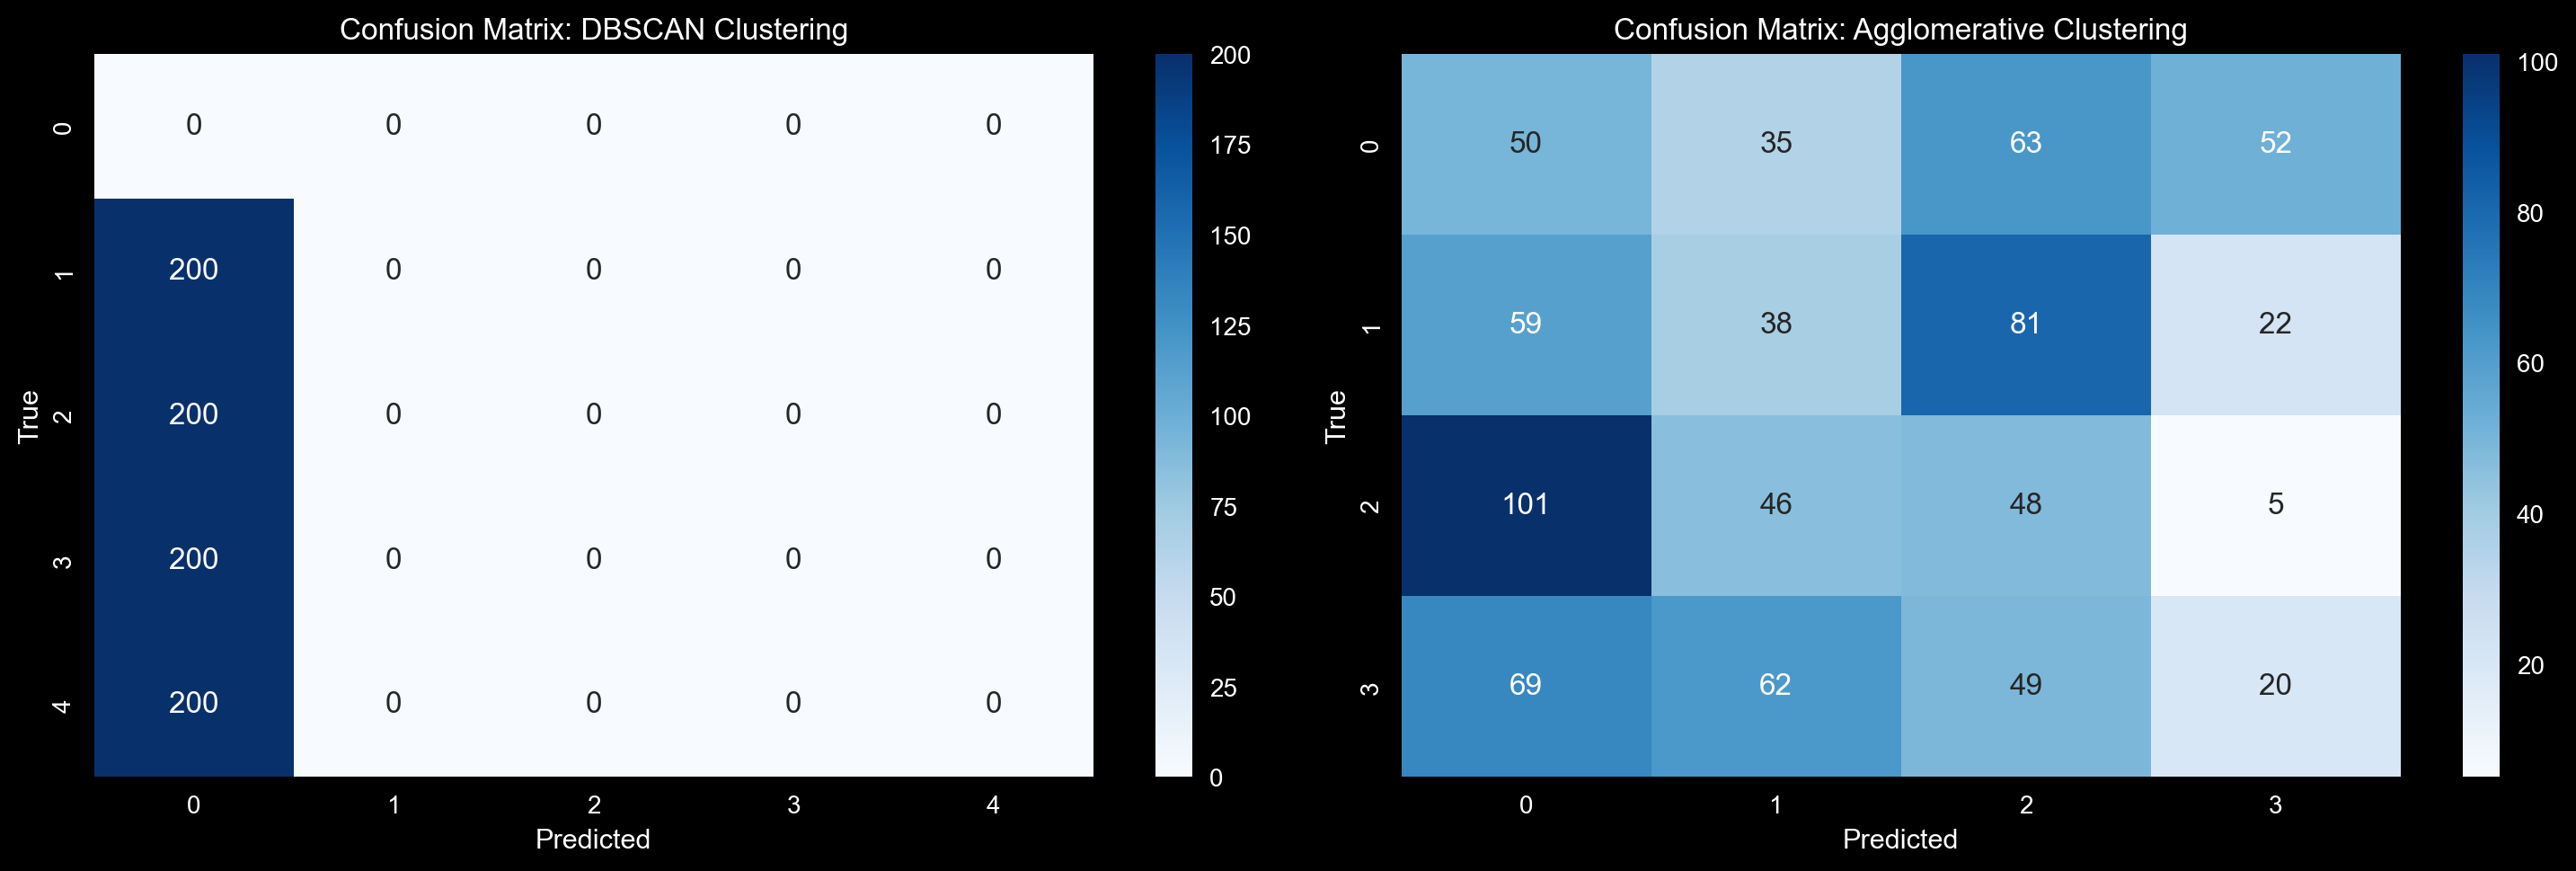

In [209]:


from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
bert_embeddings_scaled = scaler.fit_transform(bert_embeddings)

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(bert_embeddings_scaled)
documents['dbscan'] = dbscan_labels

agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_clustering.fit_predict(bert_embeddings_scaled)
documents['agg'] = agg_labels

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
sns.scatterplot(x=bert_embeddings_scaled[:, 0], y=bert_embeddings_scaled[:, 1], hue=documents['dbscan'], palette='viridis', legend='full')
plt.title('DBSCAN Clustering with BERT Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.subplot(1, 2, 2)
sns.scatterplot(x=bert_embeddings_scaled[:, 0], y=bert_embeddings_scaled[:, 1], hue=documents['agg'], palette='viridis', legend='full')
plt.title('Agglomerative Clustering with BERT Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(documents['source_num'], documents['dbscan']), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: DBSCAN Clustering')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(documents['source_num'], documents['agg']), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Agglomerative Clustering')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()